# Motivation to using Autoencoders

Autoencoder are good at:
- **dimensionality reduction** for data visualization
- **data denoising** for robust feature learning

Thus the motivation is to use Z-space of autoencoders as Path Descriptors of coupler curves.

# Enhance reproducability of results

In [0]:
#%env PYTHONHASHSEED=0 
#%env CUDA_VISIBLE_DEVICES=""

In [0]:
import numpy as np
import tensorflow as tf
import random
import os
tf.logging.set_verbosity(tf.logging.ERROR)

np.random.seed(1)
random.seed(1)
tf.set_random_seed(1)

config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=config)
K.set_session(sess)

In [0]:
def resetRNG(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.set_random_seed(seed_value)

# Import .npz Database containing 5SS mechanisms and cplr paths

In [0]:
# Import data offline
#current_dir=os.getcwd()
#db_path=os.path.join(current_dir,'..','1. DB Preprocessing','norm_database5SS.npz')
#db = np.load(db_path)

In [38]:
# Import data on Google CoLab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks
db = np.load('norm_database5SS.npz')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [39]:
print(db.files)
cplr=db['cplrData']
mech=db['mechData']

print(cplr.shape)
print(mech.shape)

['cplrData', 'mechData']
(1453, 100, 3)
(1453, 11, 3)


# Splitting the database in Train/Test dataset

In [0]:
x= cplr

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, _, _ = train_test_split(x, x, test_size=0.2, random_state=11)

# Functions to TRAIN an Autoencoder

In [0]:
from keras.layers import Input, Dense, Flatten, Reshape, SeparableConv1D, concatenate
from keras.models import Model, load_model
from keras.layers import LeakyReLU
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
#from keras import initializers
import keras

In [0]:
# Train same model architecture multiple times since the training process is stochastic

def AE_analysis(AE_model, iterations, x_train, x_test, filename='model'):
    val_loss_list=[]
    best_val_loss=np.inf;
    for i in range(iterations):
        print('Model no. '+str(i+1))
        AE, E = AE_model()
        val_loss, train_data=train_AE(AE, E, x_train, x_test)
        val_loss_list.append(val_loss)
        if best_val_loss>val_loss:
            best_AE=AE
            best_E=E
            best_train_data=train_data
            best_val_loss=val_loss
    
    # PRINT MEAN, VARIANCE and BEST MODEL METRICS
    print(val_loss_list)
    print('Average Validation Loss: '+str(np.mean(val_loss_list)))
    
    # SAVE BEST MODEL
    AEfilename='AE_'+filename+'_val_loss_'+str(best_val_loss)+'.h5'
    AEfilepath=os.path.join('models',AEfilename)
    best_AE.save(AEfilepath)
    
    return best_AE, best_E, best_train_data

In [0]:
def train_AE(autoencoder, encoder, x_train, x_test, epochs=500):
    # TRAINING PHASE
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min',
                                  restore_best_weights=True)
    autoencoder_train=autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=128, 
                                      shuffle=False, validation_data=(x_test, x_test), 
                                      verbose=0, callbacks=[earlyStopping])
    
    # TRAINING DATA
    val_loss = autoencoder_train.history['val_loss']
    f_val_loss=np.round_(val_loss[-1],decimals=4)
    
    return f_val_loss, autoencoder_train

# Functions to VISUALIZE an Autoencoder

In [0]:
def visualize_AE(AE, train_data, x_test):
    # VISUALIZING TRAINING CURVES
    visualize_train_curves(train_data)
    
    # VISUALIZE RECONSTRUCTED CURVES
    reconst_curve = AE.predict(x_test)
    visualize_reconstructed_CplrCurves(x_test, reconst_curve, 10)

    
def visualize_train_curves(train_data):
    loss = train_data.history['loss']
    val_loss = train_data.history['val_loss']
    
    f_loss=np.round_(loss[-1],decimals=4)
    f_val_loss=np.round_(val_loss[-1],decimals=4)
    
    print('Training loss: '+str(f_loss))
    print('Validation loss: '+str(f_val_loss))
    
    epochsRange = range(len(loss))
    plt.figure()
    plt.plot(epochsRange, loss, 'r', label='Training loss')
    plt.plot(epochsRange, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def visualize_reconstructed_CplrCurves(x_test, reconst_curve, n=10, b_spline=False):
    fig= plt.figure(figsize=(3*4, 3*n))
    fig.suptitle('Isometric (3D), Top (X-Y Plane), Front (X-Z Plane) and Right (Y-Z Plane) View', fontsize=14, fontweight='bold')
    for i in range(n):
        # Isometric View
        ax = plt.subplot(n, 4, 4*i+1, projection='3d')
        if b_spline:
            reconst_curve[i]=b_spline_interpolation(reconst_curve[i], 100)
        plotPath3D(reconst_curve[i], ax, 2,'r' )
        plotPath3D(x_test[i], ax, 2)
        
        #x-y, x-z, y-z plane view
        xy_recon=reconst_curve[i,:,0:2]
        xy_orig=x_test[i,:,0:2]
        xz_recon=np.concatenate(([reconst_curve[i,:,0]], [reconst_curve[i,:,2]]),axis=0).T
        xz_orig=np.concatenate(([x_test[i,:,0]], [x_test[i,:,2]]),axis=0).T
        yz_recon=reconst_curve[i,:,1:3]
        yz_orig=x_test[i,:,1:3]
        
        # Top View
        ax = plt.subplot(n, 4, 4*i+2)
        plotPath(xy_recon, ax, 2,'r' )
        plotPath(xy_orig, ax, 2)
        
        # Front View
        ax = plt.subplot(n, 4, 4*i+3)
        plotPath(xz_recon, ax, 2,'r' )
        plotPath(xz_orig, ax, 2)
        
        # Right View
        ax = plt.subplot(n, 4, 4*i+4)
        plotPath(yz_recon, ax, 2,'r' )
        plotPath(yz_orig, ax, 2)
        
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [0]:
# Plotting Functions

%matplotlib inline
#%matplotlib notebook
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy import interpolate


def plotPath3D(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, color)
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])
    
def plotPath(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    ax.plot(xline, yline, color)
    ax.set(xlim=(-limit, limit), ylim=(-limit, limit))

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))


def b_spline_interpolation(inp_pts, out_n):
    # Fit cubic B-spline to the points
    xp=inp_pts[i,:,0]
    yp=inp_pts[i,:,1]
    zp=inp_pts[i,:,2]
        
    # Check for duplicate points as interpolation routine errors out
    okay = np.where(np.abs(np.diff(xp)) + np.abs(np.diff(yp)) + np.abs(np.diff(zp)) > 0)
    xp = np.r_[xp[okay], xp[-1]]
    yp = np.r_[yp[okay], yp[-1]]
    zp = np.r_[zp[okay], zp[-1]]
    
    tck, u =interpolate.splprep([xp,yp,zp],s=1)
    num_pts=out_n
    u_fine = np.linspace(0,1,num_pts)
    x_f, y_f, z_f = interpolate.splev(u_fine, tck)
    Path_f = np.vstack(([x_100],[y_100],[z_100])).T
    
    return Path_f

# 1. Effect of activation func: Sigmoid vs RELU vs LeakyRELU

First we try to find which activation function might perform better for our usecase i.e. describing 3D coupler paths. Each model is trained 10 times for 200 epochs and the best fit model results are reported. The Training Loss and Validation Loss after training are

| Activation Function | Mean Validation Loss | Best Validation Loss |
|:-------------------:|:--------------------:|:--------------------:|
| Sigmoid             | 0.0122               | 0.0056
| RELU                | 0.0066               | 0.0032
| LeakyRELU           | 0.0063               | 0.0036


## 1.1 Autoencoder Sigmoid activation

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00434: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00402: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00374: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00411: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00471: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00431: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00426: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00352: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00167: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00418: early stopping
[0.0053, 0.0055, 0.0063, 0.0053, 0.0055, 0.0055, 

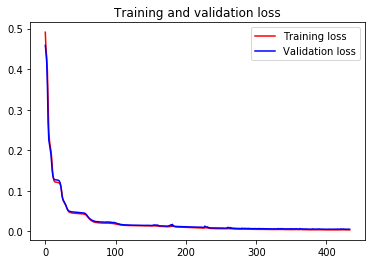

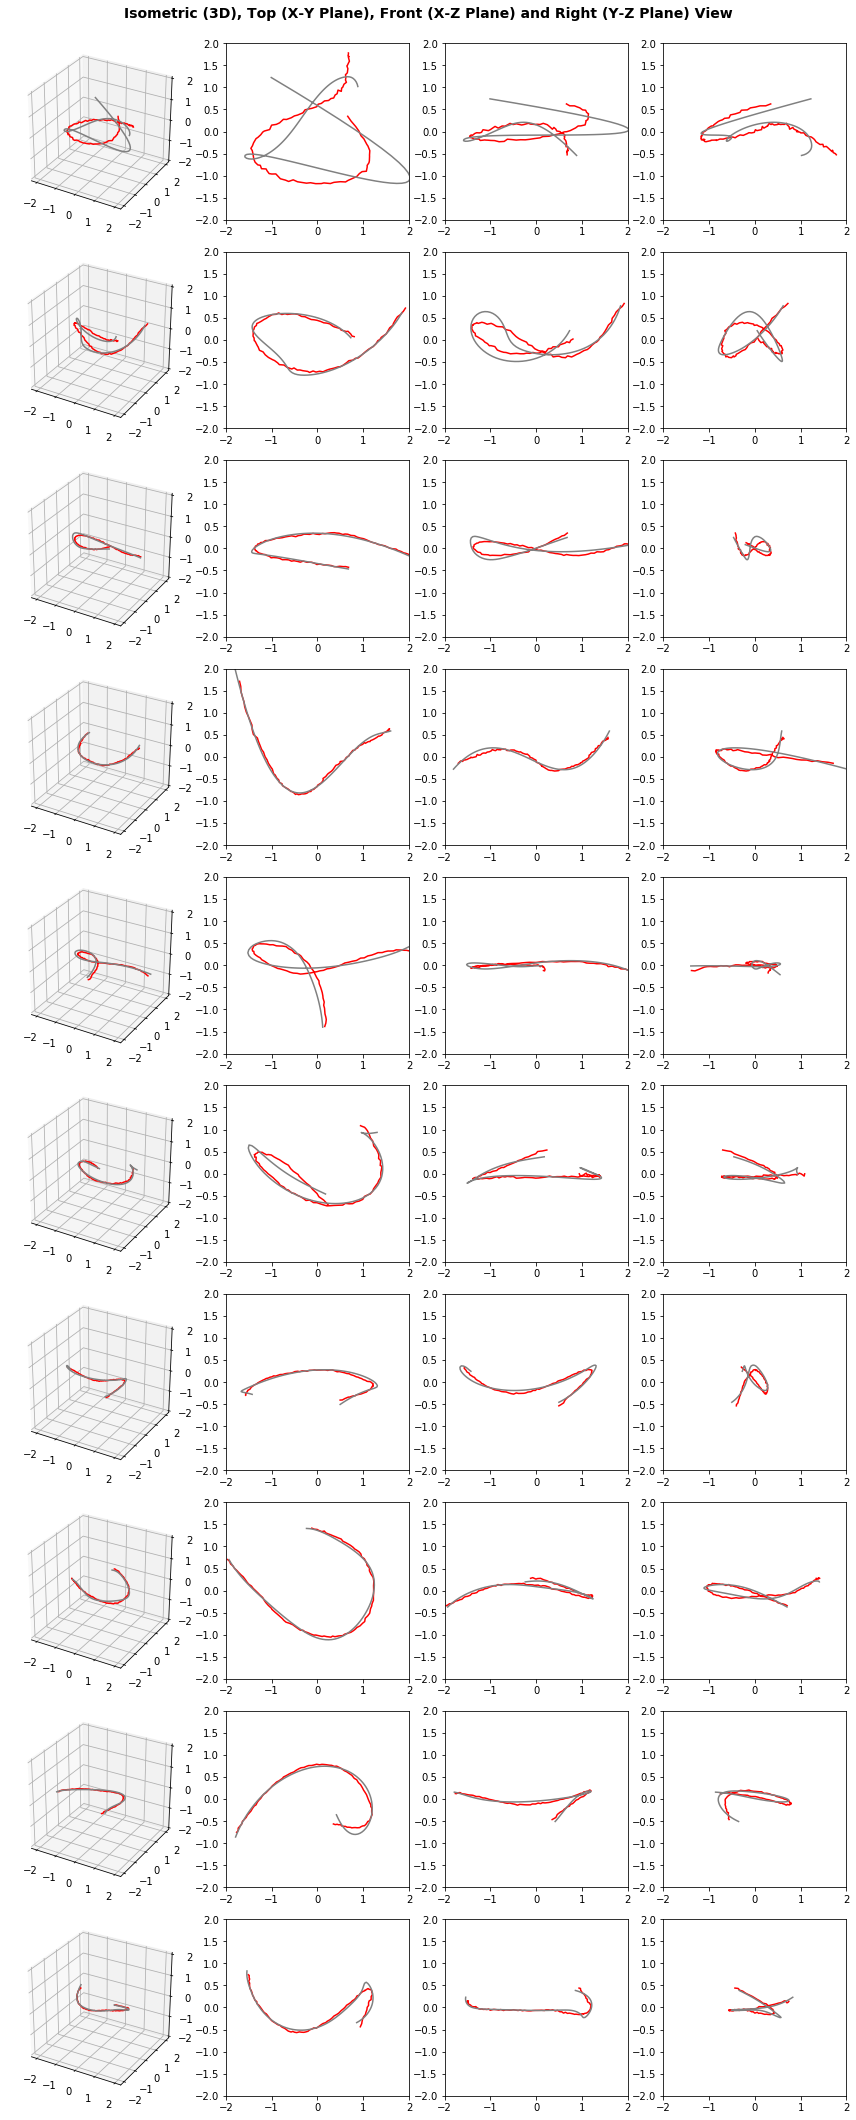

In [46]:
def autoEncoderSig():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(300, activation='sigmoid')(x)
    x=Dense(200, activation='sigmoid')(x)
    encoded=Dense(100, activation='sigmoid')(x)

    # Decoding
    x=Dense(200, activation='sigmoid')(encoded)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
#autoencoderSig, encoderSig=autoEncoderSig()
#testAutoEncoder(autoencoderSig, encoderSig, x_train, x_test, filepath='AE_Sig')

AE,E,train_data =AE_analysis(autoEncoderSig, 10, x_train, x_test, filename='Sig')
visualize_AE(AE, train_data, x_test)

## 1.2 Autoencoder RELU activation

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00231: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00139: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00196: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00167: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00187: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00127: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00220: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00198: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00135: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00193: early stopping
[0.0017, 0.0031, 0.0017, 0.0019, 0.0015, 0.0038, 

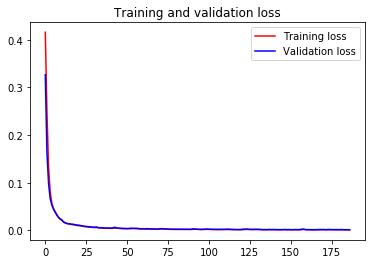

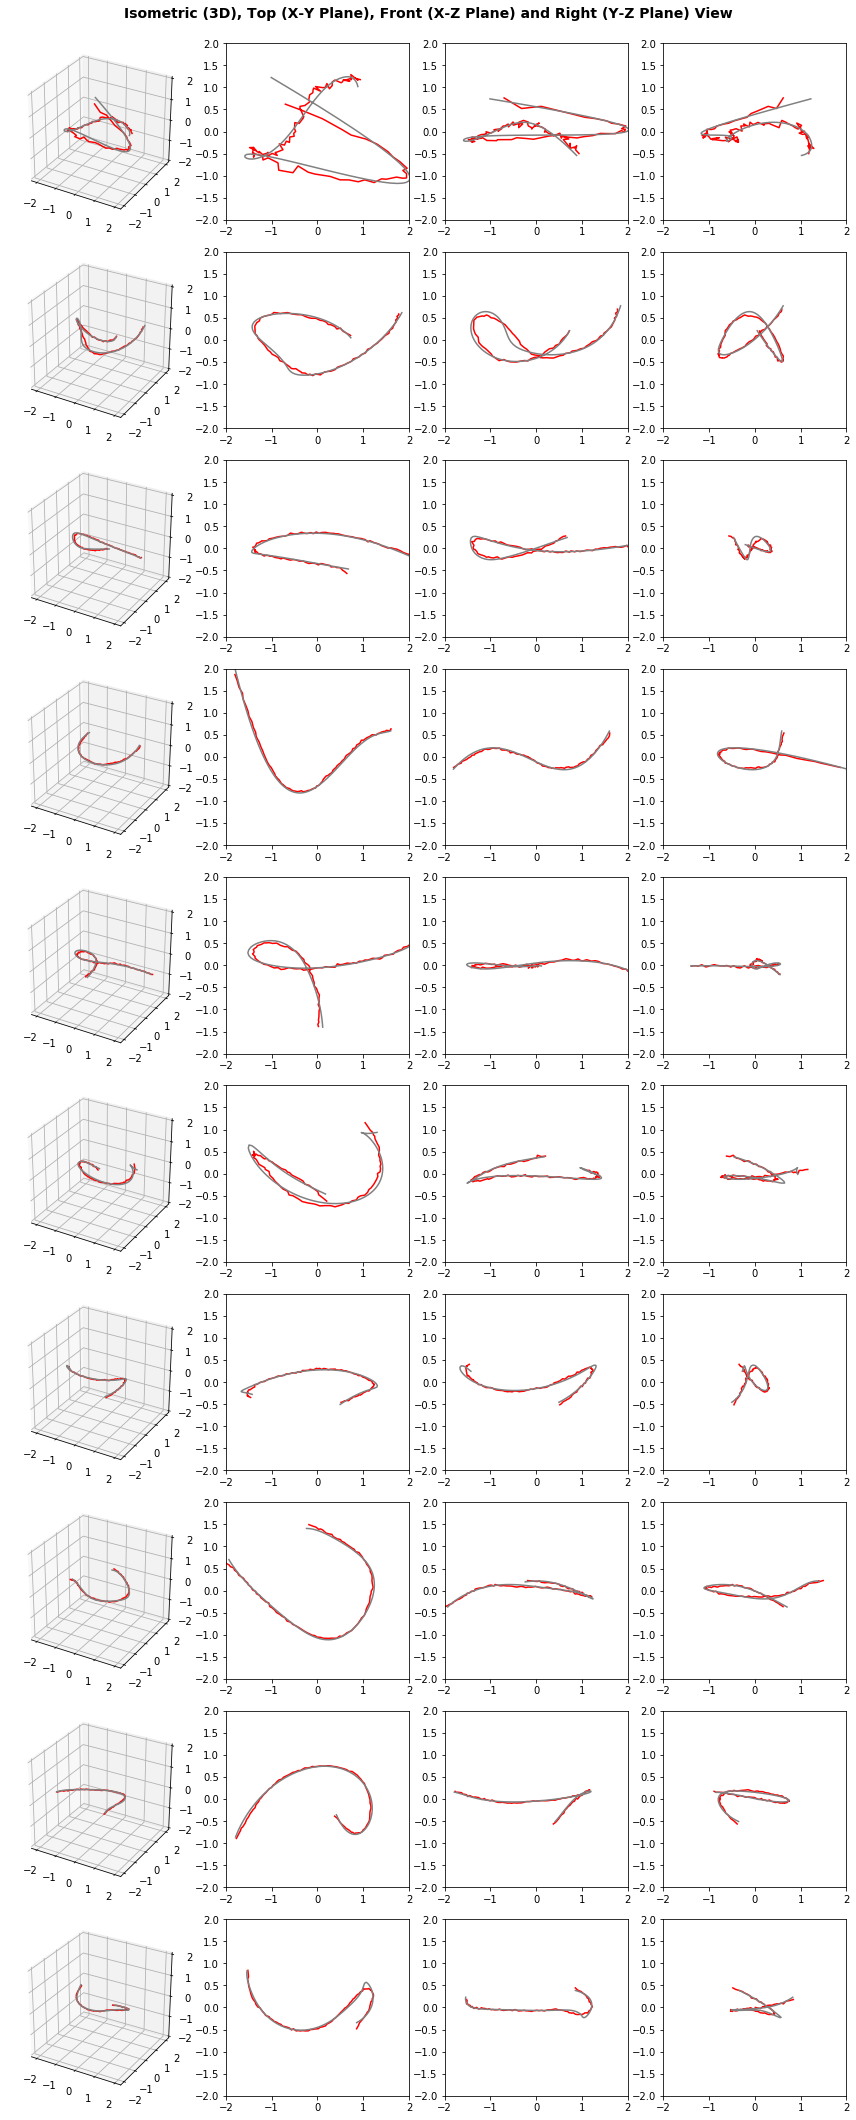

In [47]:
def autoEncoderRELU():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(300, activation='sigmoid')(x)
    x=Dense(200, activation='relu')(x)
    encoded=Dense(100, activation='relu')(x)

    # Decoding
    x=Dense(200, activation='relu')(encoded)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderRELU, 10, x_train, x_test, filename='RELU')
visualize_AE(AE, train_data, x_test)

## 1.3 Autoencoder LeakyRELU activation

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00159: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00132: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00102: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00071: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00116: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00093: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00092: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00113: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00128: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00100: early stopping
[0.004, 0.0041, 0.006, 0.0054, 0.0047, 0.0055, 0.

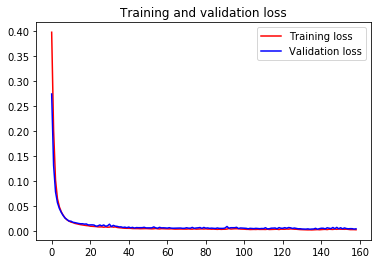

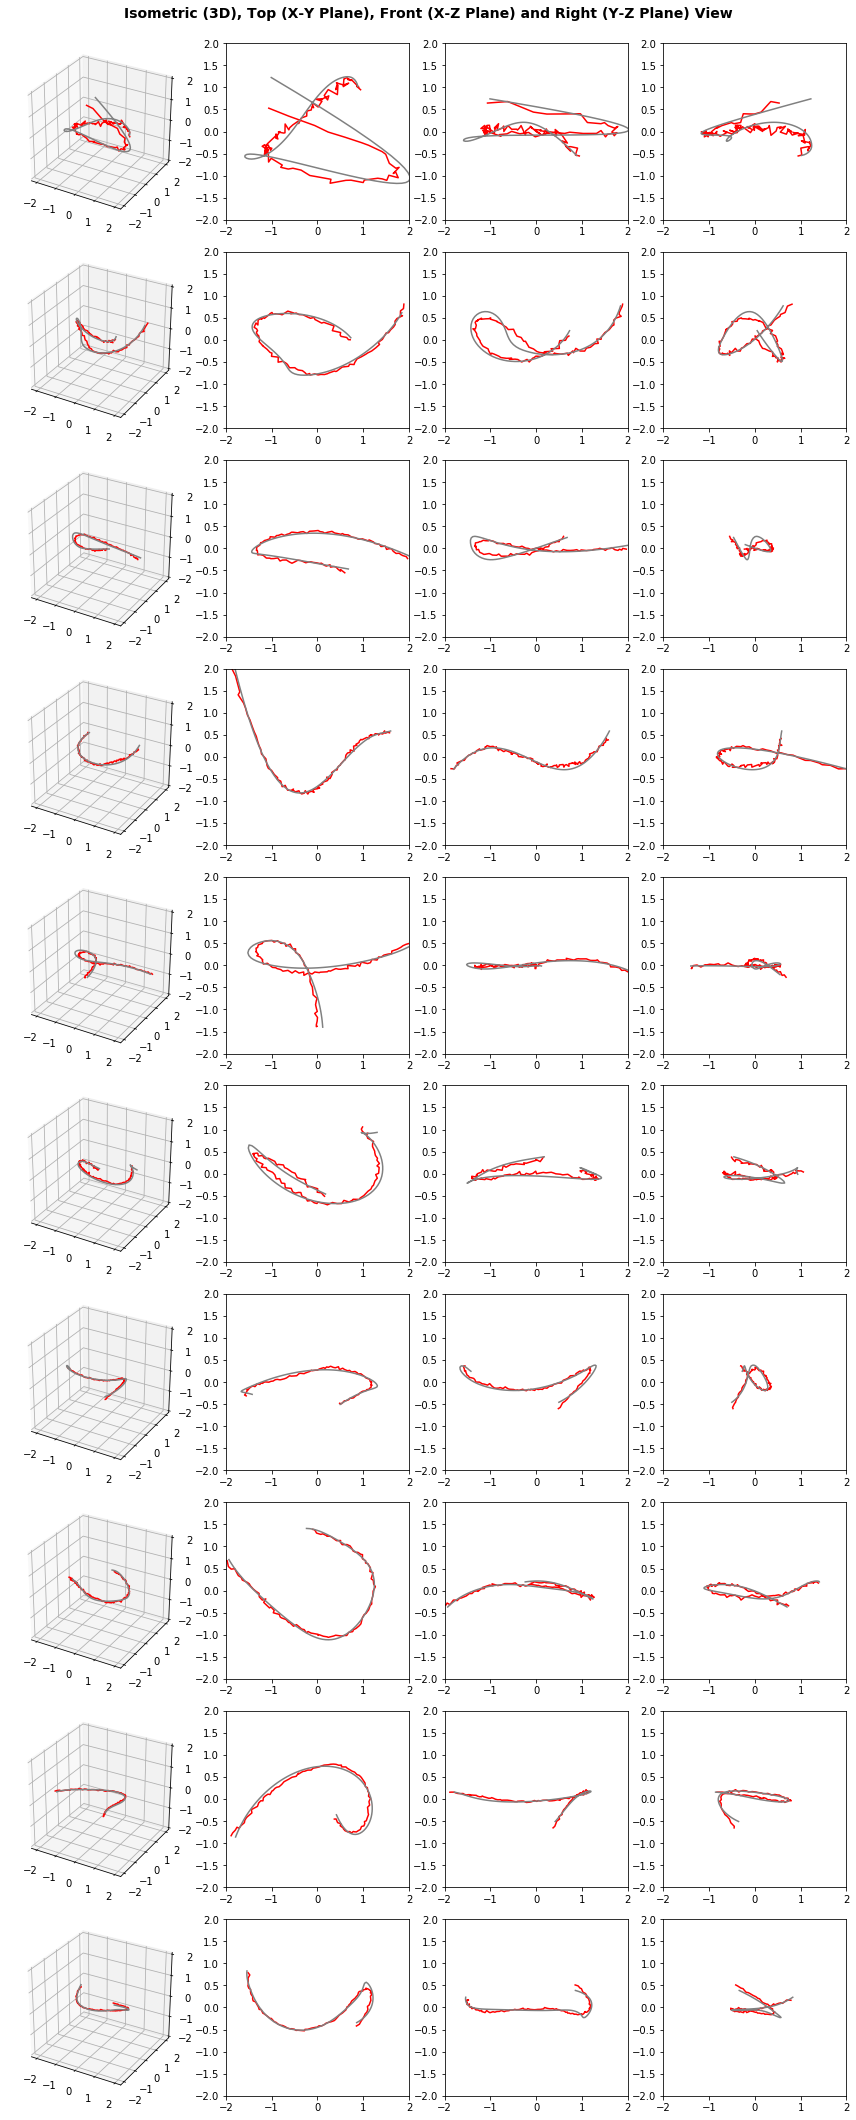

In [48]:
def autoEncoderLRELU():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(300)(x)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(200)(x)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(100)(x)
    encoded=LeakyReLU(alpha=0.01)(x)

    # Decoding
    x=Dense(200)(encoded)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderLRELU, 10, x_train, x_test, filename='LRELU')
visualize_AE(AE, train_data, x_test)

# 2. Effect of Latent space Z=2,3,10,15,30,60,300 on Dense Auto-Encoders

The nodes in Z-space determines the dimensionity reduction carried out by an auto-encoder. However, if the z-space is too small, the accuracy of reconstruction is adversely affected. Thus, we carry an emperical analysis to find the best accuracy-dimentionality tradeoff.

| Z-Space Dimension   | Mean Validation Loss | Best Validation Loss |
|:-------------------:|:--------------------:|:--------------------:|
| 2                   | 0.1026               | 0.0492
| 3                   | 0.0693               | 0.0435
| 10                  | 0.0187               | 0.0148
| 15                  | 0.0156               | 0.0137
| 30                  | 0.0057               | 0.0038
| 60                  | 0.0027               | 0.0020
| 300                 | 0.0022               | 0.0019


Reconstruction losses for Z=2,3,10 are significant. However, we don't observe a lot of improvement in reconstructed results after Z=30. Thus, exploring architectures from Z=15 to Z=30 seems to be the sweet spot.

## 2.1 Autoencoder Z=2

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00197: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00081: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00094: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00280: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00247: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00035: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00138: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00171: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00109: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00211: early stopping
[0.12, 0.1332, 0.1372, 0.1083, 0.1178, 0.2083, 0.

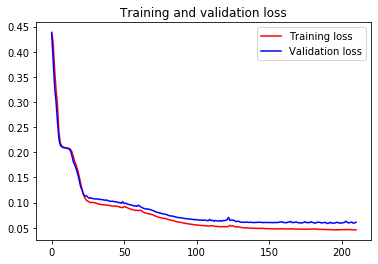

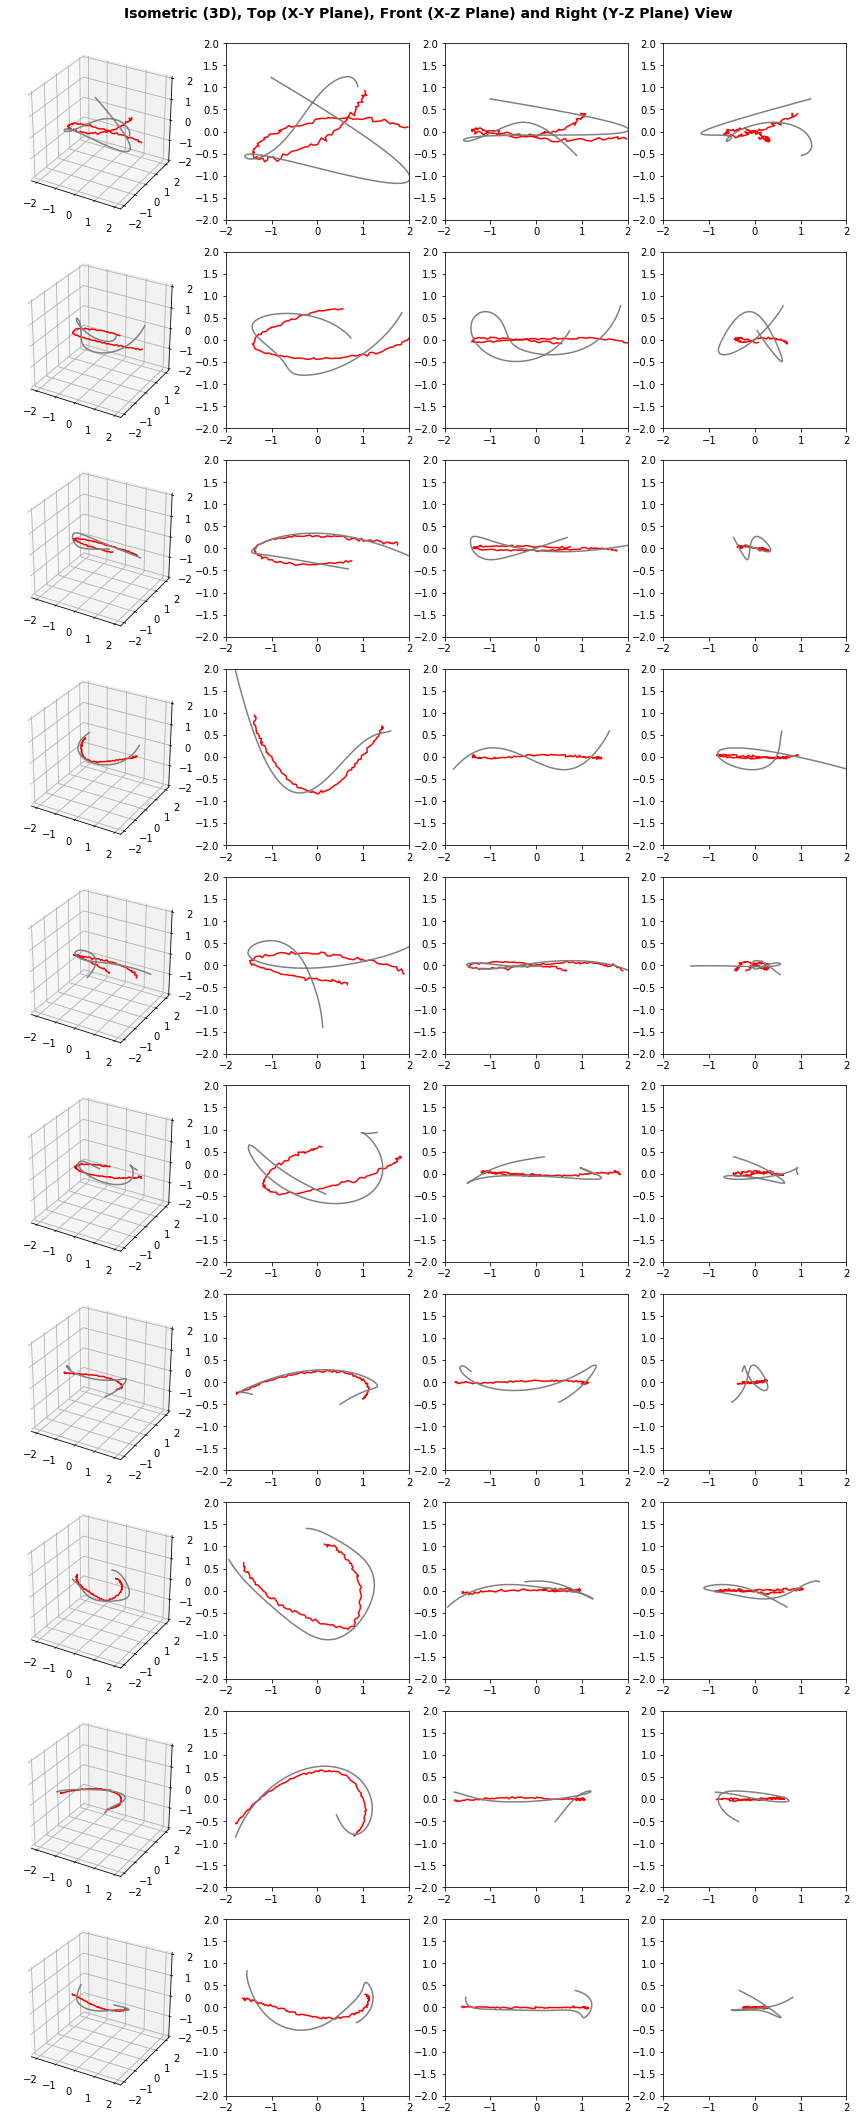

In [49]:
def autoEncoderZ2():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(20, activation='relu')(x)
    x=Dense(10, activation='relu')(x)
    x=Dense(5, activation='relu')(x)
    encoded=Dense(2, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(5, activation='relu')(encoded)
    x=Dense(10, activation='relu')(x)
    x=Dense(20, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderZ2, 10, x_train, x_test, filename='Z2')
visualize_AE(AE, train_data, x_test)

## 2.2 Autoencoder Z=3

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00262: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00184: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00244: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00154: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00331: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00177: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00260: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00270: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00198: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00254: early stopping
[0.051, 0.0585, 0.0458, 0.0541, 0.0393, 0.0645, 0

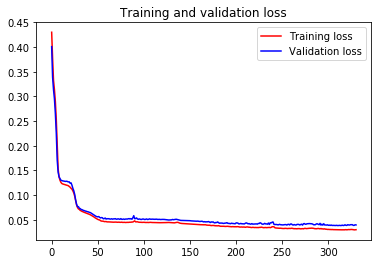

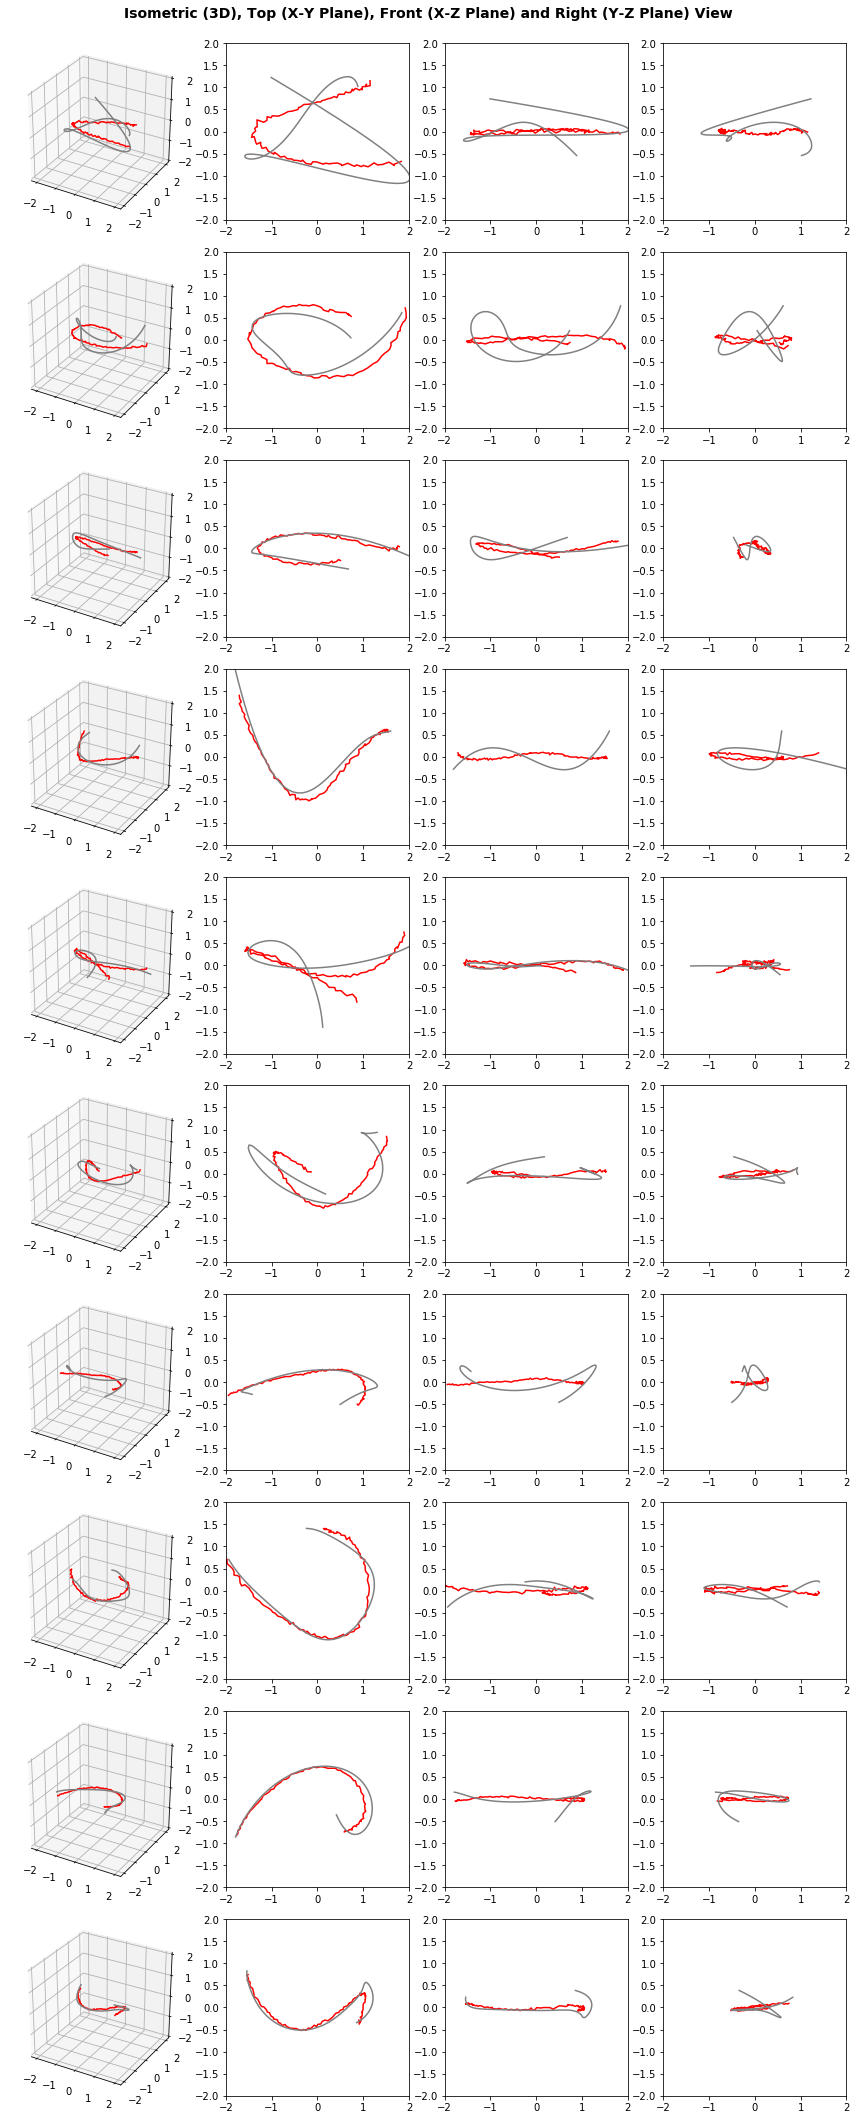

In [50]:
def autoEncoderZ3():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(20, activation='relu')(x)
    x=Dense(10, activation='relu')(x)
    encoded=Dense(3, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(10, activation='relu')(encoded)
    x=Dense(20, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderZ3, 10, x_train, x_test, filename='Z3')
visualize_AE(AE, train_data, x_test)

## 2.3 Autoencoder Z=10

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00172: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00115: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00148: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00138: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00222: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00150: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00146: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00203: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00215: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00166: early stopping
[0.019, 0.0198, 0.0185, 0.0187, 0.0195, 0.02, 0.0

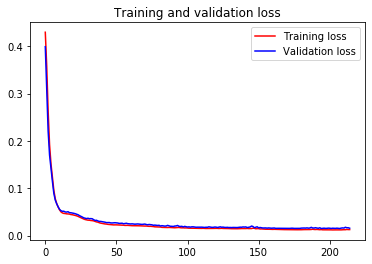

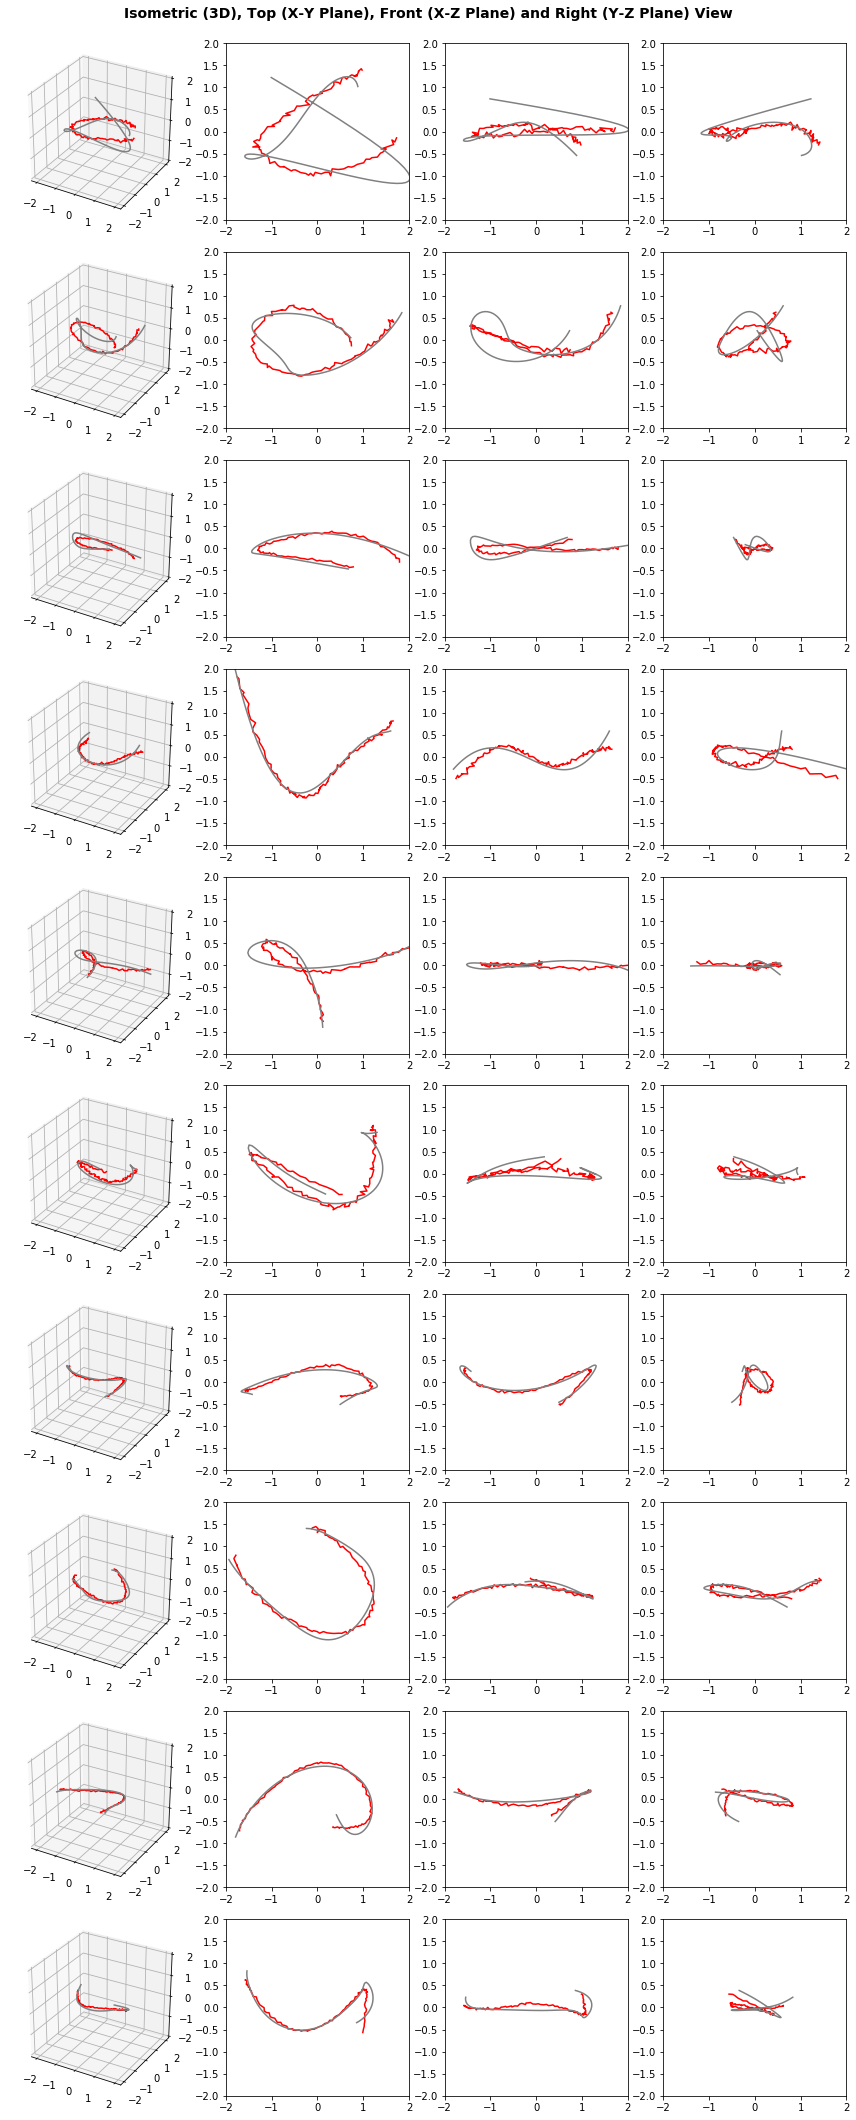

In [51]:
def autoEncoderZ10():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(50, activation='relu')(x)
    x=Dense(25, activation='relu')(x)
    encoded=Dense(10, activation='relu')(x)

    # Decoding
    x=Dense(25, activation='relu')(encoded)
    x=Dense(50, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderZ10, 10, x_train, x_test, filename='Z10')
visualize_AE(AE, train_data, x_test)

## 2.4 Autoencoder Z=15

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00194: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00292: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00319: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00151: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00175: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00161: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00325: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00202: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00247: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00298: early stopping
[0.013, 0.012, 0.0107, 0.0149, 0.0144, 0.0151, 0.

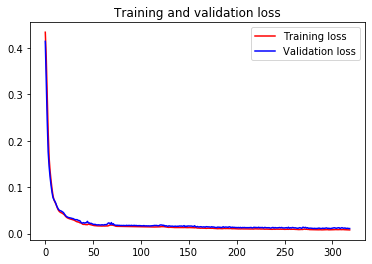

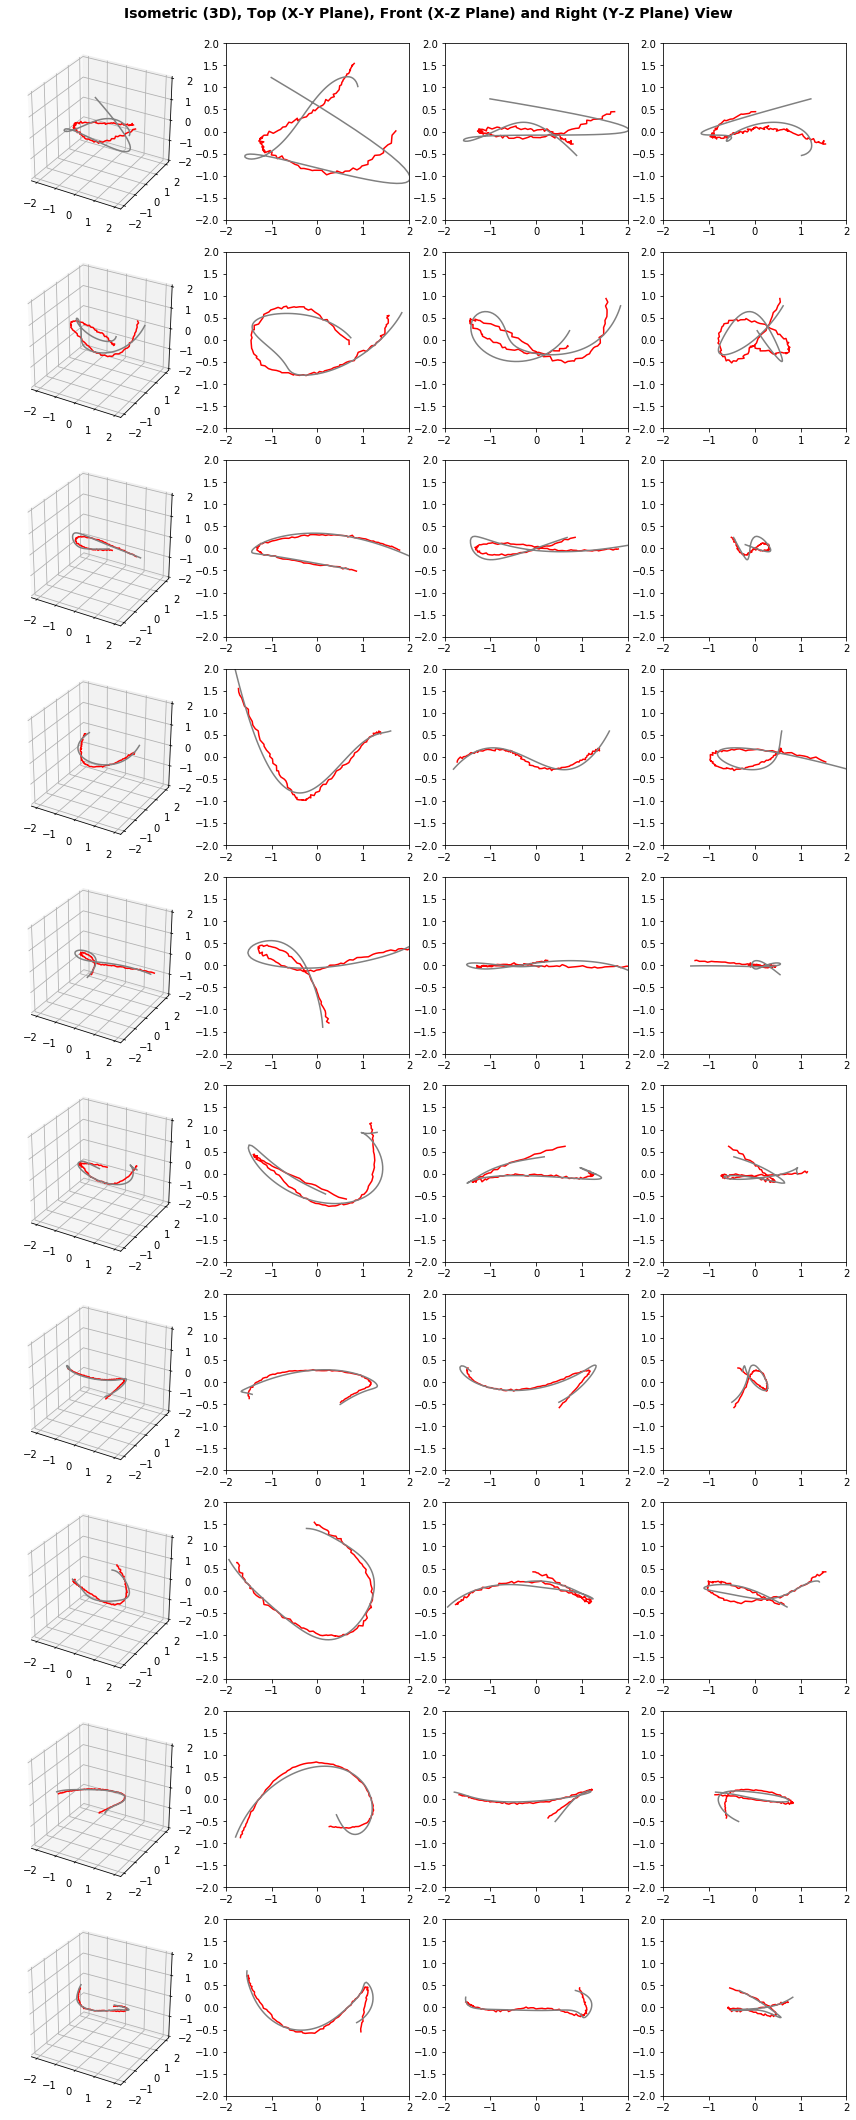

In [52]:
def autoEncoderZ15():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(60, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    encoded=Dense(15, activation='relu')(x)

    # Decoding
    x=Dense(30, activation='relu')(encoded)
    x=Dense(60, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderZ15, 10, x_train, x_test, filename='Z15')
visualize_AE(AE, train_data, x_test)

## 2.5 Autoencoder Z=30

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00210: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00159: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00219: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00156: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00173: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00138: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00149: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00235: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00163: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00212: early stopping
[0.0053, 0.0068, 0.0052, 0.0052, 0.0063, 0.0068, 

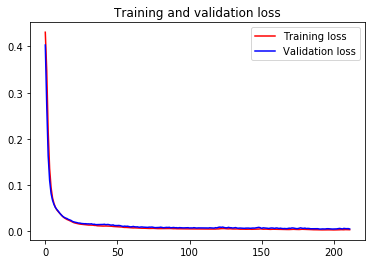

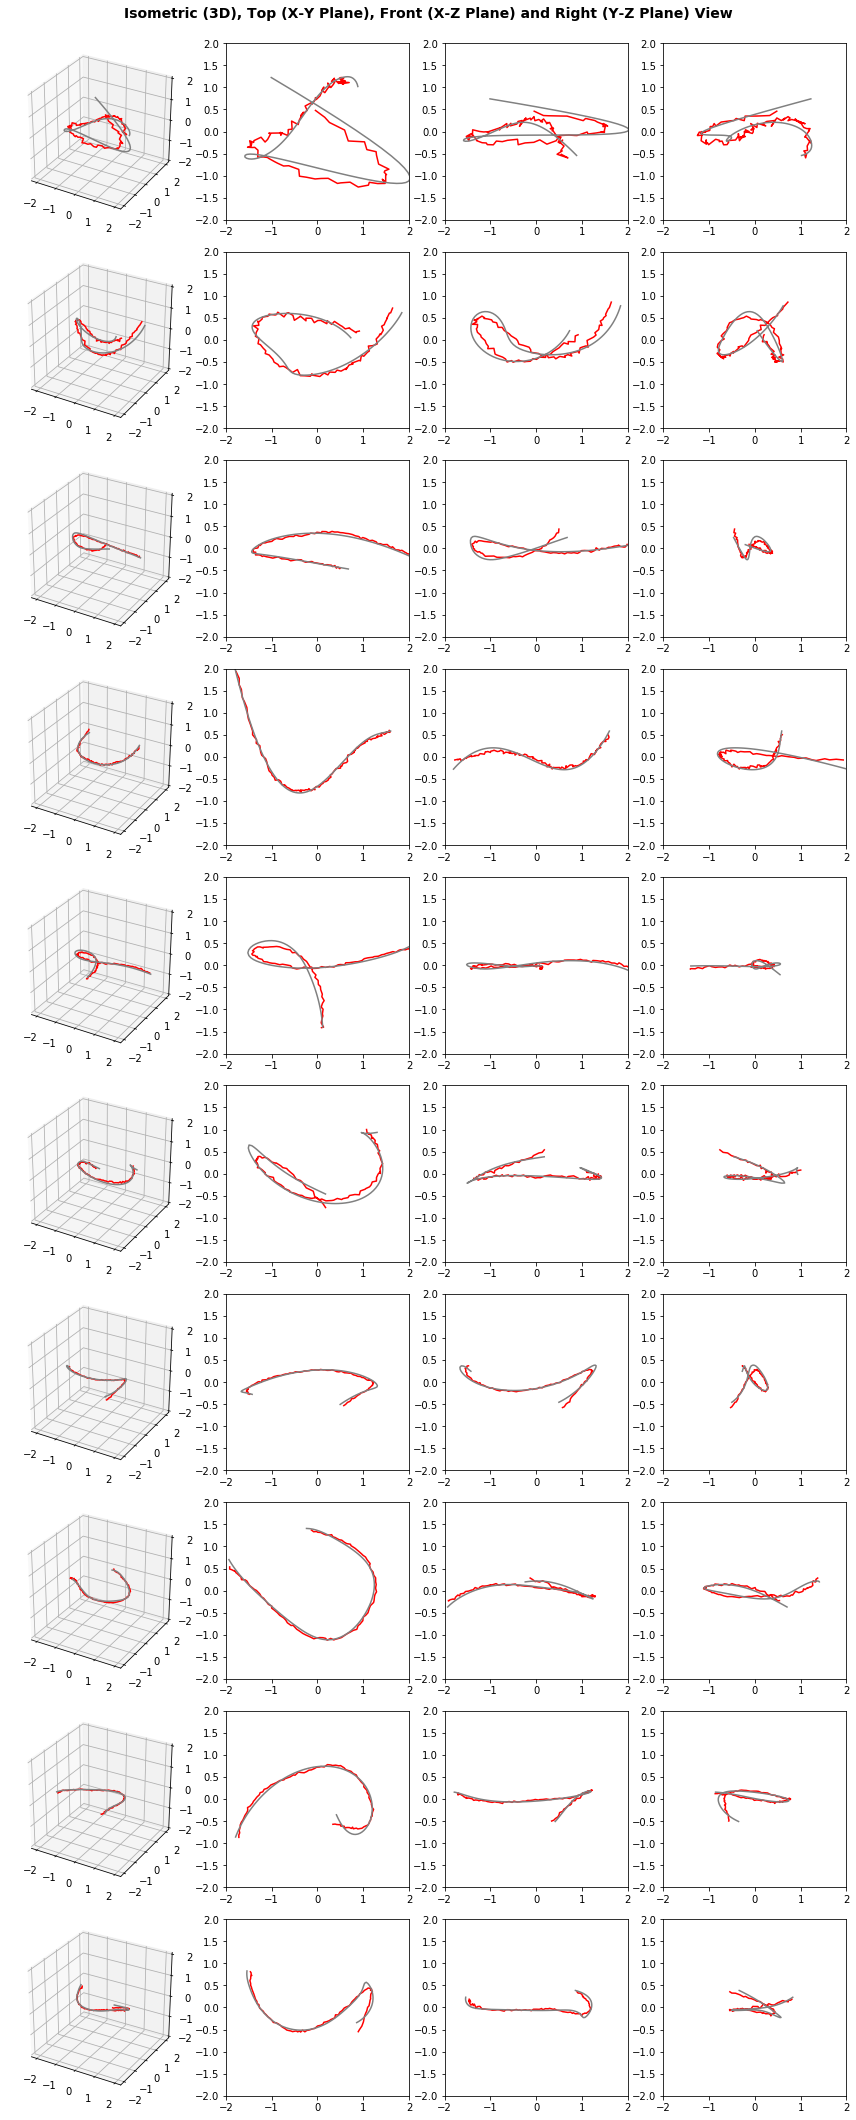

In [53]:
def autoEncoderZ30():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(60, activation='relu')(x)
    encoded=Dense(30, activation='relu')(x)

    # Decoding
    x=Dense(60, activation='relu')(encoded)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderZ30, 10, x_train, x_test, filename='Z30')
visualize_AE(AE, train_data, x_test)

## 2.6 Autoencoder Z=60

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00164: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00185: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00183: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00118: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00120: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00126: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00193: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00186: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00125: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00193: early stopping
[0.0028, 0.0025, 0.0025, 0.0046, 0.0032, 0.0033, 

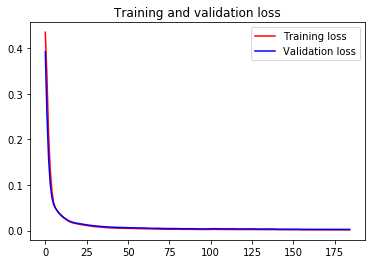

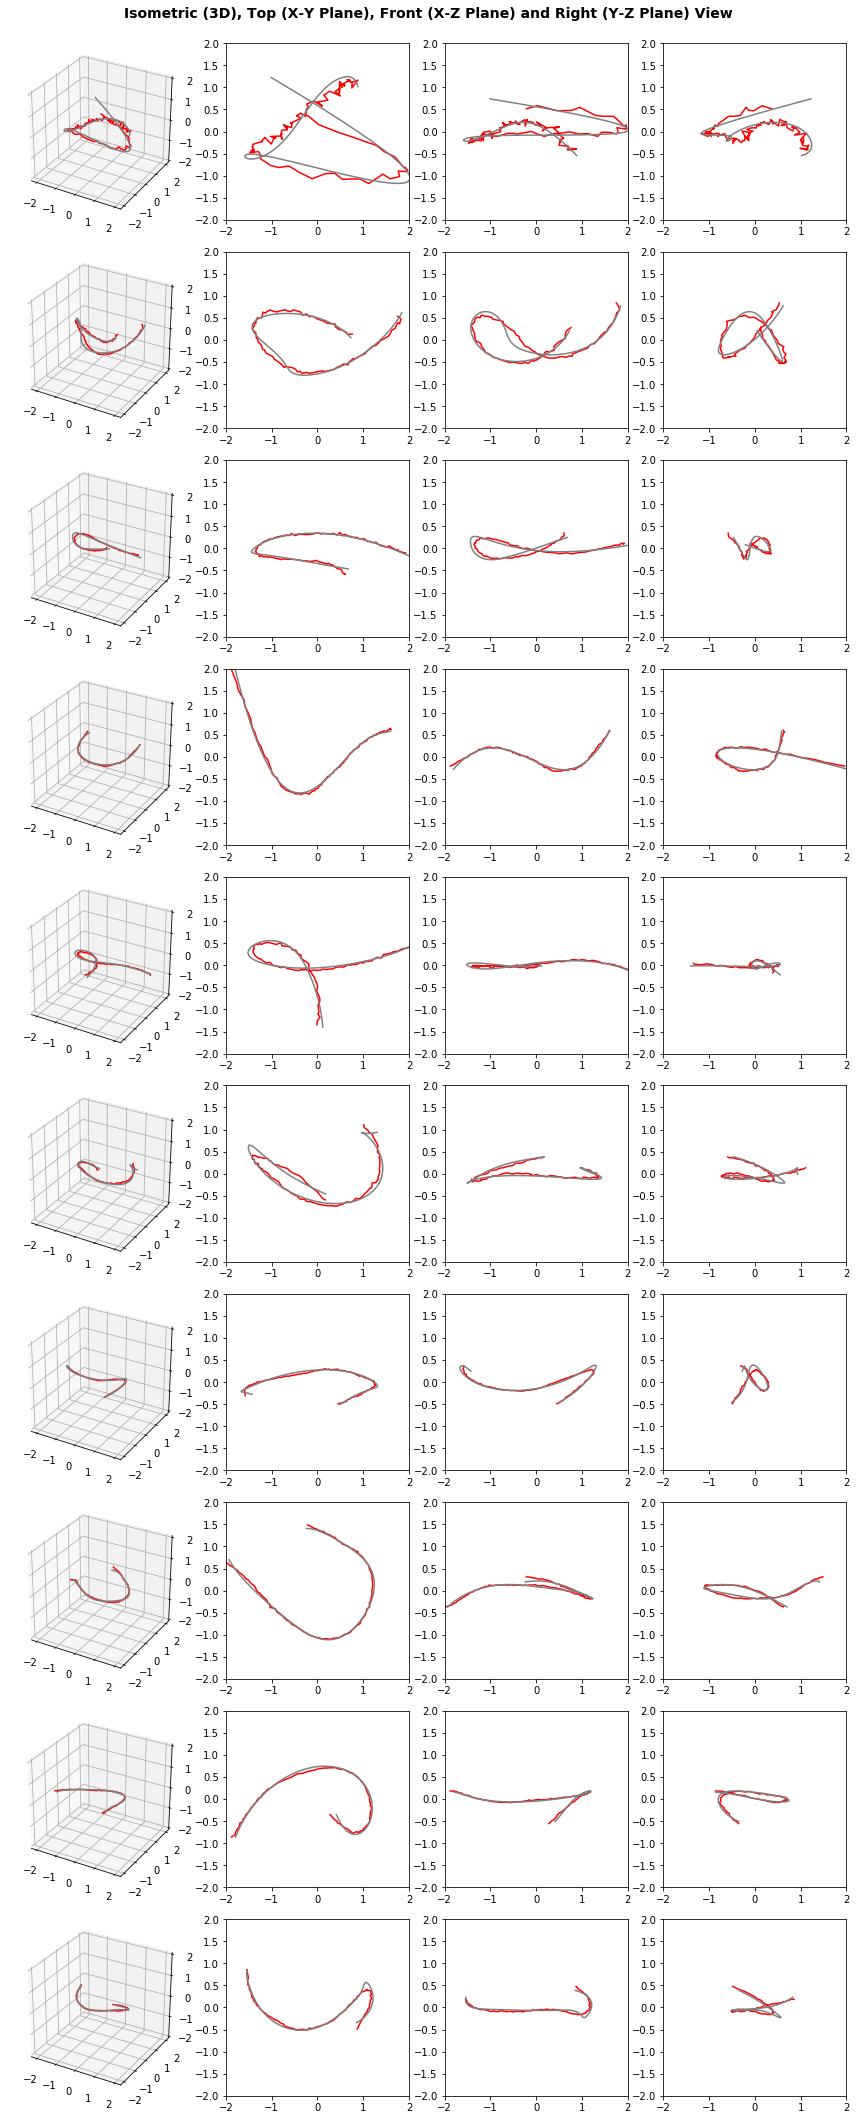

In [54]:
def autoEncoderZ60():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    encoded=Dense(60, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(100, activation='relu')(encoded)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderZ60, 10, x_train, x_test, filename='Z60')
visualize_AE(AE, train_data, x_test)

## 2.7 AutoEncoder Z=300

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00089: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00108: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00112: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00147: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00129: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00163: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00120: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00121: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00096: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00130: early stopping
[0.0026, 0.0021, 0.0028, 0.0021, 0.0019, 0.0023, 

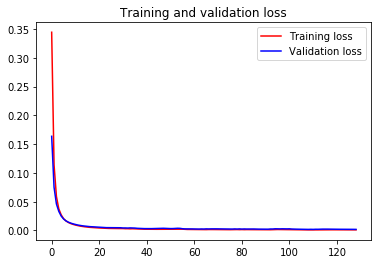

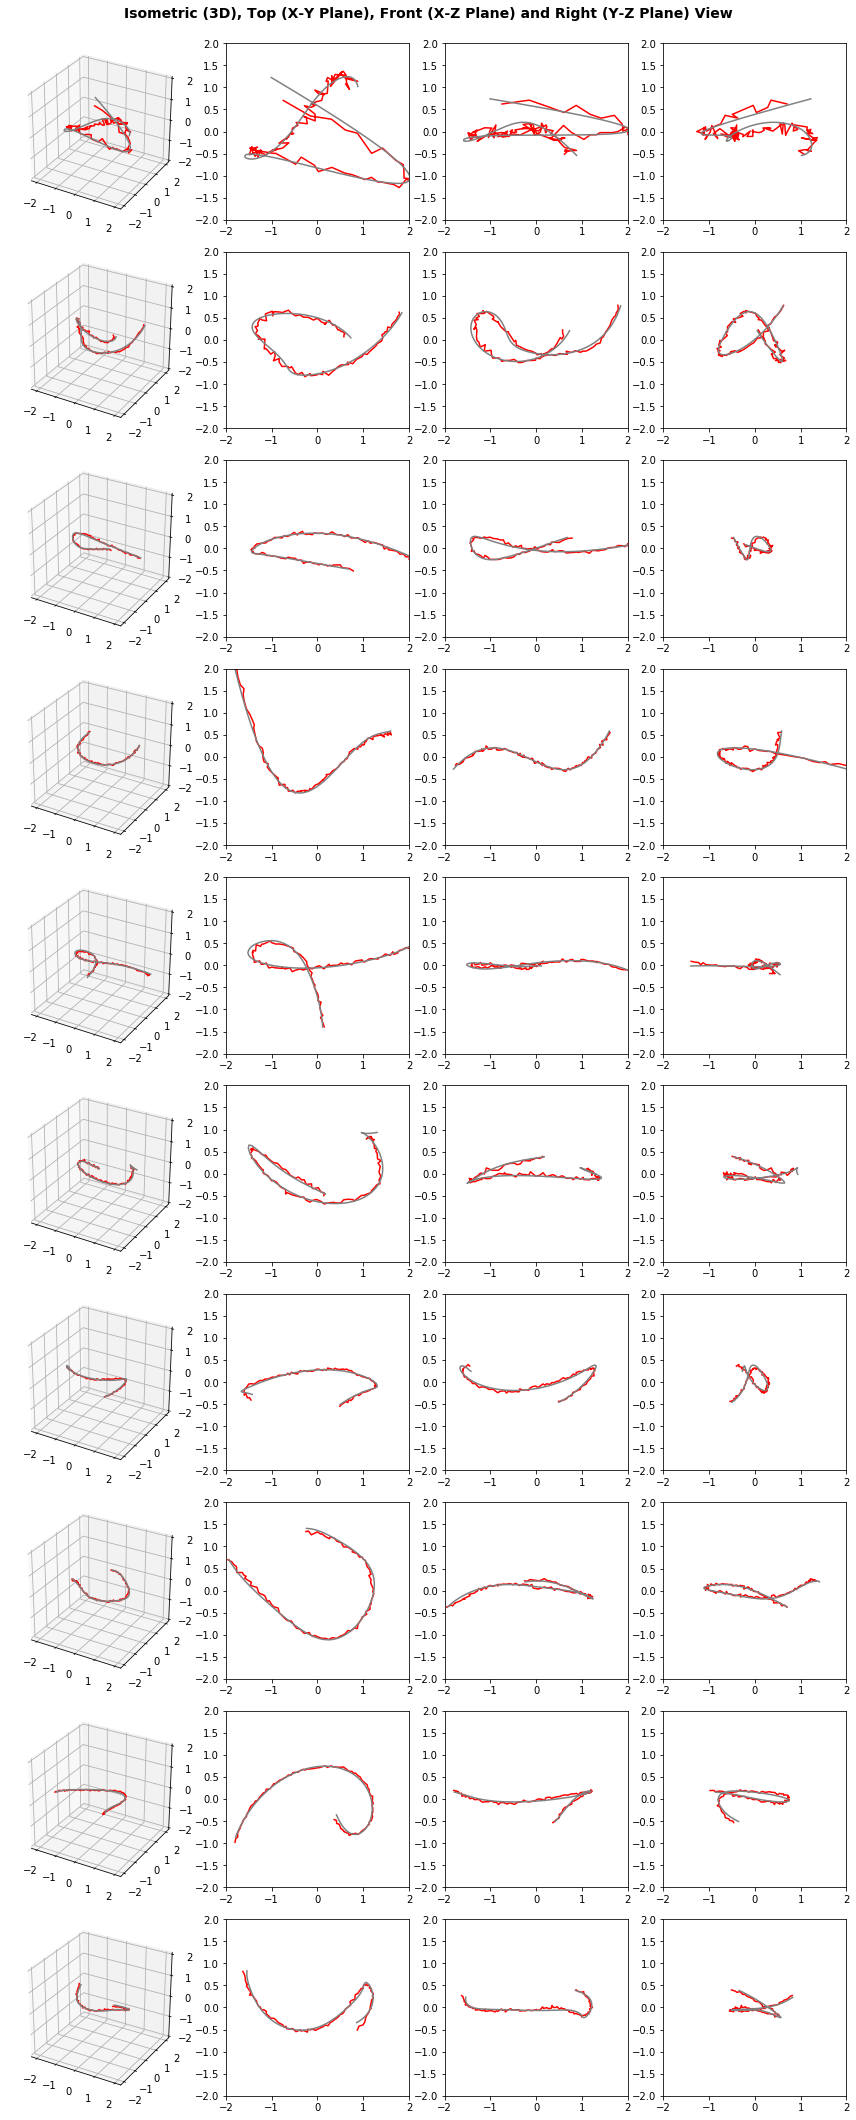

In [55]:
def autoEncoderZ300():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(300, activation='relu')(x)
    encoded=Dense(300, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(300)(encoded)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderZ300, 10, x_train, x_test, filename='Z300')
visualize_AE(AE, train_data, x_test)

# 3. Effect of Regularization

Regularizing the bottleneck layer enforces the z-space to be better behaved i.e. the output range is smaller. This leads to 'reduced activity' in z-space and the model generalizes better and avoids overfitting. However, the validation loss for each model increases by increasing regularization due to added regularization term in the cost function. Thus, optimal regularization parameter needs to be emperically explored.

We use l1 regularizer scaled by a constant factor $\lambda=10^{-7}$ in our implementation.

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00367: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00163: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00182: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00263: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00130: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00098: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00275: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00099: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00230: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00144: early stopping
[0.0414, 0.062, 0.0547, 0.0508, 0.0573, 0.0556, 0

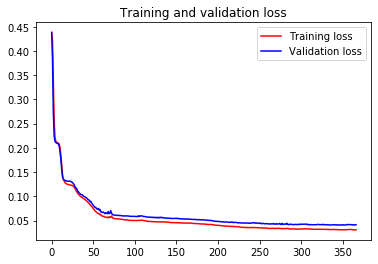

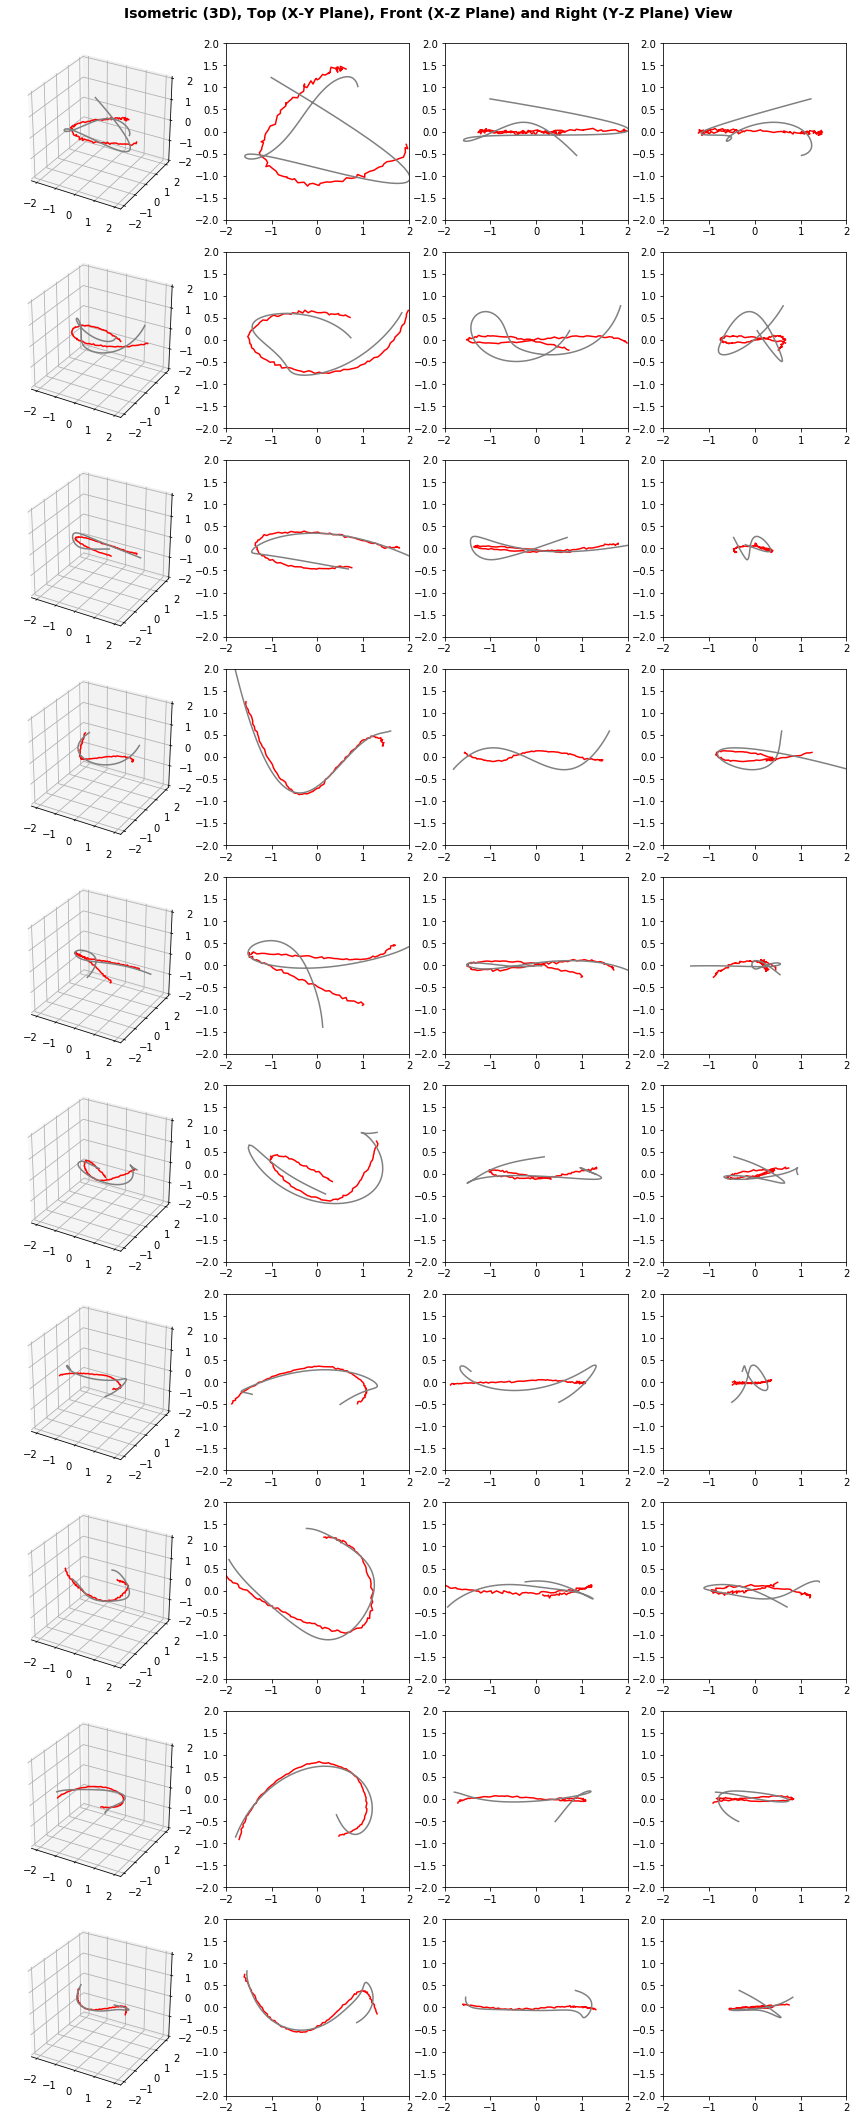

In [56]:
def autoEncoderRZ3():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(20, activation='relu')(x)
    x=Dense(10, activation='relu')(x)
    encoded=Dense(3, activation='relu',activity_regularizer=regularizers.l1(10e-7))(x)

    # Decoding
    x=Dense(10, activation='relu')(encoded)
    x=Dense(20, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)


    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderRZ3, 10, x_train, x_test, filename='RZ3')
visualize_AE(AE, train_data, x_test)

In [0]:
# Load Autoencoder model with Z=3
def loadAE(filename, bottleneckIndex):
  path=os.path.join('models',filename)
  AE = load_model(path)
  E = Model(AE.input, AE.layers[6].output)
  E.summary()

  return AE, E

def plotZspace(E, x_train, x_test):
    # Calculate z space descriptors
    z_train = E.predict(x_train)
    z_test = E.predict(x_test)
    
    fig = plt.figure(figsize=3/2*plt.figaspect(1/2))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(z_train[:,0],z_train[:,1],z_train[:,2])
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter(z_test[:,0],z_test[:,1],z_test[:,2])

    plt.tight_layout()
    plt.show()

    print('Mean train activation: '+str(z_train.mean()))
    print('Mean train activation: '+str(z_test.mean()))


Model: "model_316"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_91 (InputLayer)        (None, 100, 3)            0         
_________________________________________________________________
flatten_91 (Flatten)         (None, 300)               0         
_________________________________________________________________
dense_583 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_584 (Dense)            (None, 30)                3030      
_________________________________________________________________
dense_585 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_586 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_587 (Dense)            (None, 3)                 33

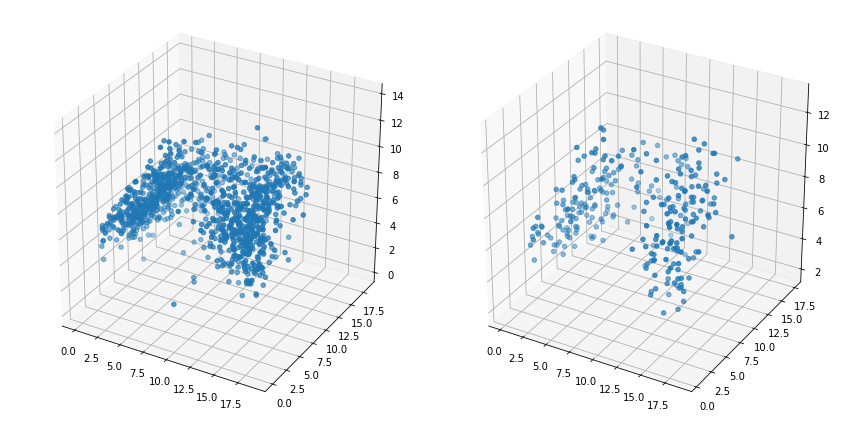

Mean train activation: 7.8731837
Mean train activation: 7.99982


In [66]:
AE_Z3,E_Z3=loadAE('AE_Z3_val_loss_0.0393.h5',6)
plotZspace(E_Z3, x_train, x_test)

Model: "model_318"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_147 (InputLayer)       (None, 100, 3)            0         
_________________________________________________________________
flatten_147 (Flatten)        (None, 300)               0         
_________________________________________________________________
dense_933 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_934 (Dense)            (None, 30)                3030      
_________________________________________________________________
dense_935 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_936 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_937 (Dense)            (None, 3)                 33

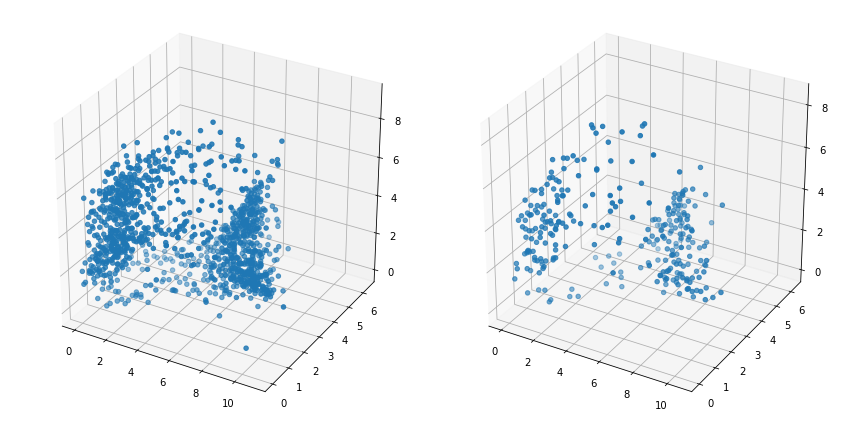

Mean train activation: 3.3989334
Mean train activation: 3.4010444


In [69]:
AE_RZ3,E_RZ3=loadAE('AE_RZ3_val_loss_0.0414.h5',6)
plotZspace(E_RZ3, x_train, x_test)

# Effect of Deep AutoEncoders

As the depth of an autoencoder increases, it can capture more complex relationships in the data. 

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00208: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00149: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00228: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00208: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00184: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00204: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00166: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00123: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00116: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00133: early stopping
[0.0222, 0.0254, 0.0252, 0.0219, 0.0205, 0.0248, 

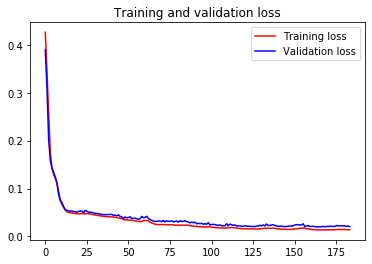

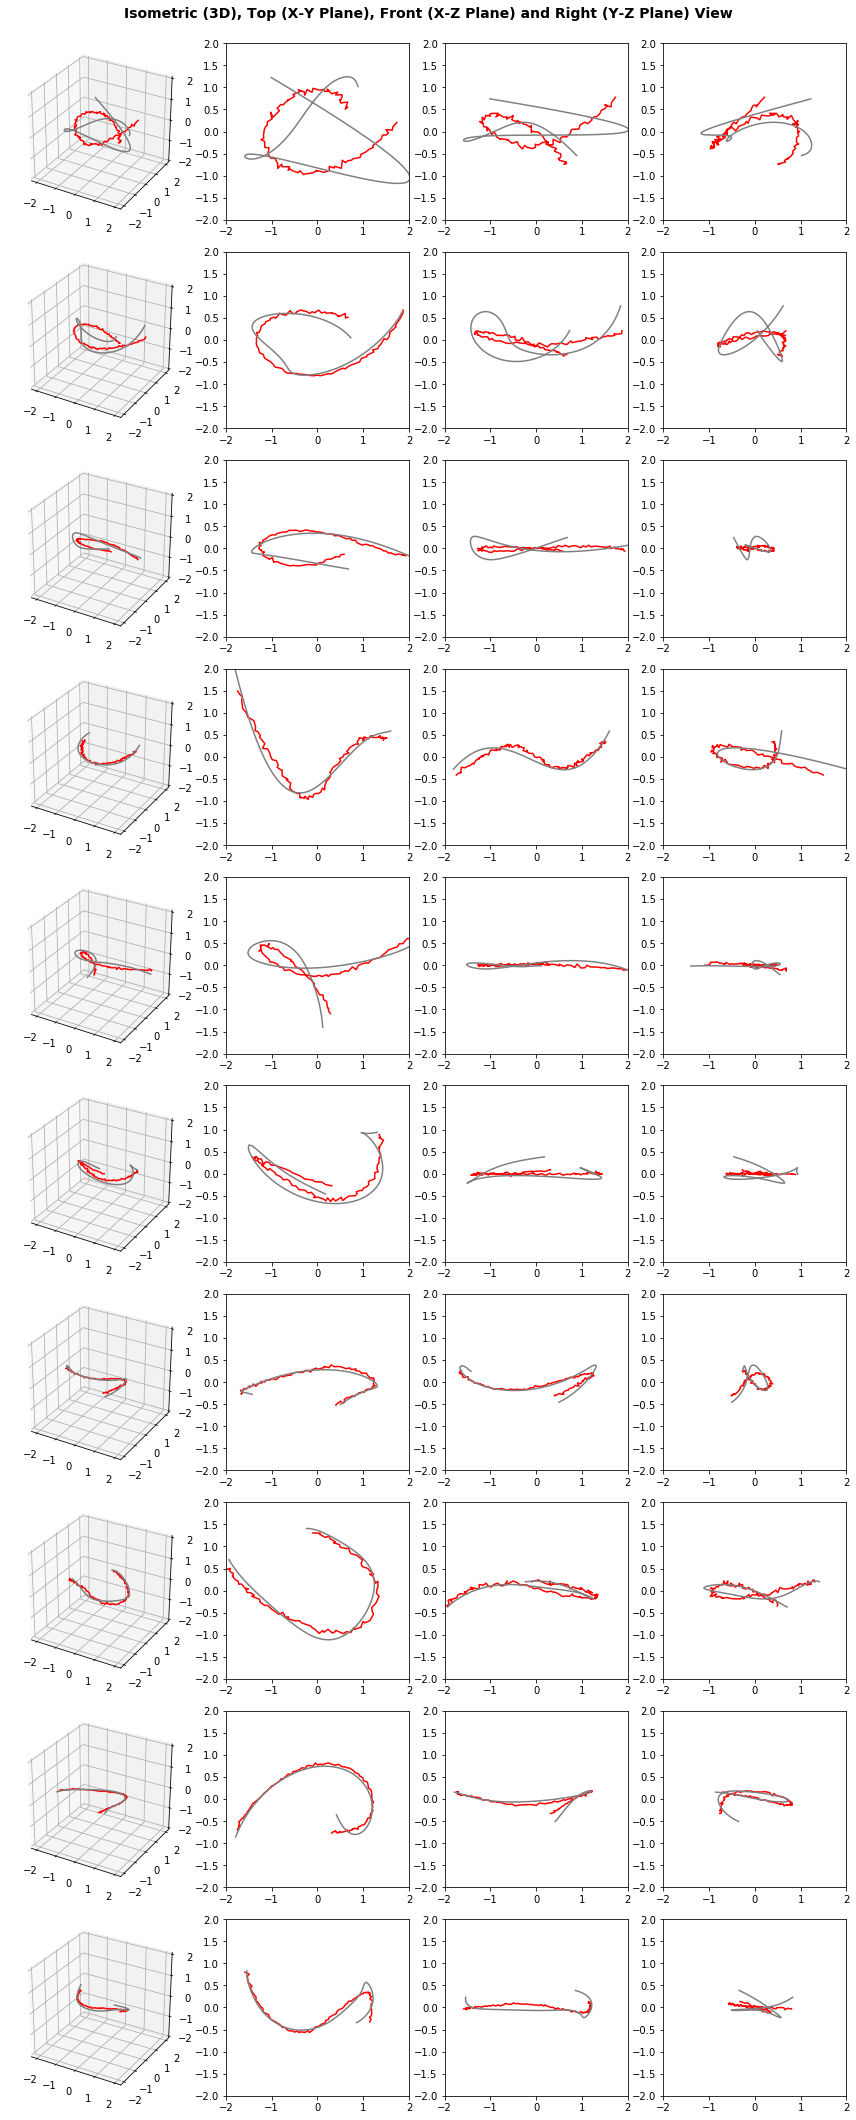

In [70]:
def autoEncoderRZ30_Deep():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(150, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(80, activation='relu')(x)
    x=Dense(60, activation='relu')(x)
    x=Dense(40, activation='relu')(x)
    encoded=Dense(30, activation='relu',activity_regularizer=regularizers.l1(10e-7))(x)

    # Decoding
    x=Dense(40, activation='relu')(encoded)
    x=Dense(60, activation='relu')(x)
    x=Dense(80, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderRZ30_Deep, 10, x_train, x_test, filename='RZ30_Deep')
visualize_AE(AE, train_data, x_test)

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00159: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00138: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00156: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00156: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00117: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00086: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00154: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00120: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00146: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00180: early stopping
[0.021, 0.0203, 0.019, 0.0226, 0.026, 0.0271, 0.0

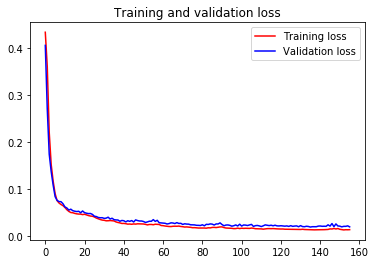

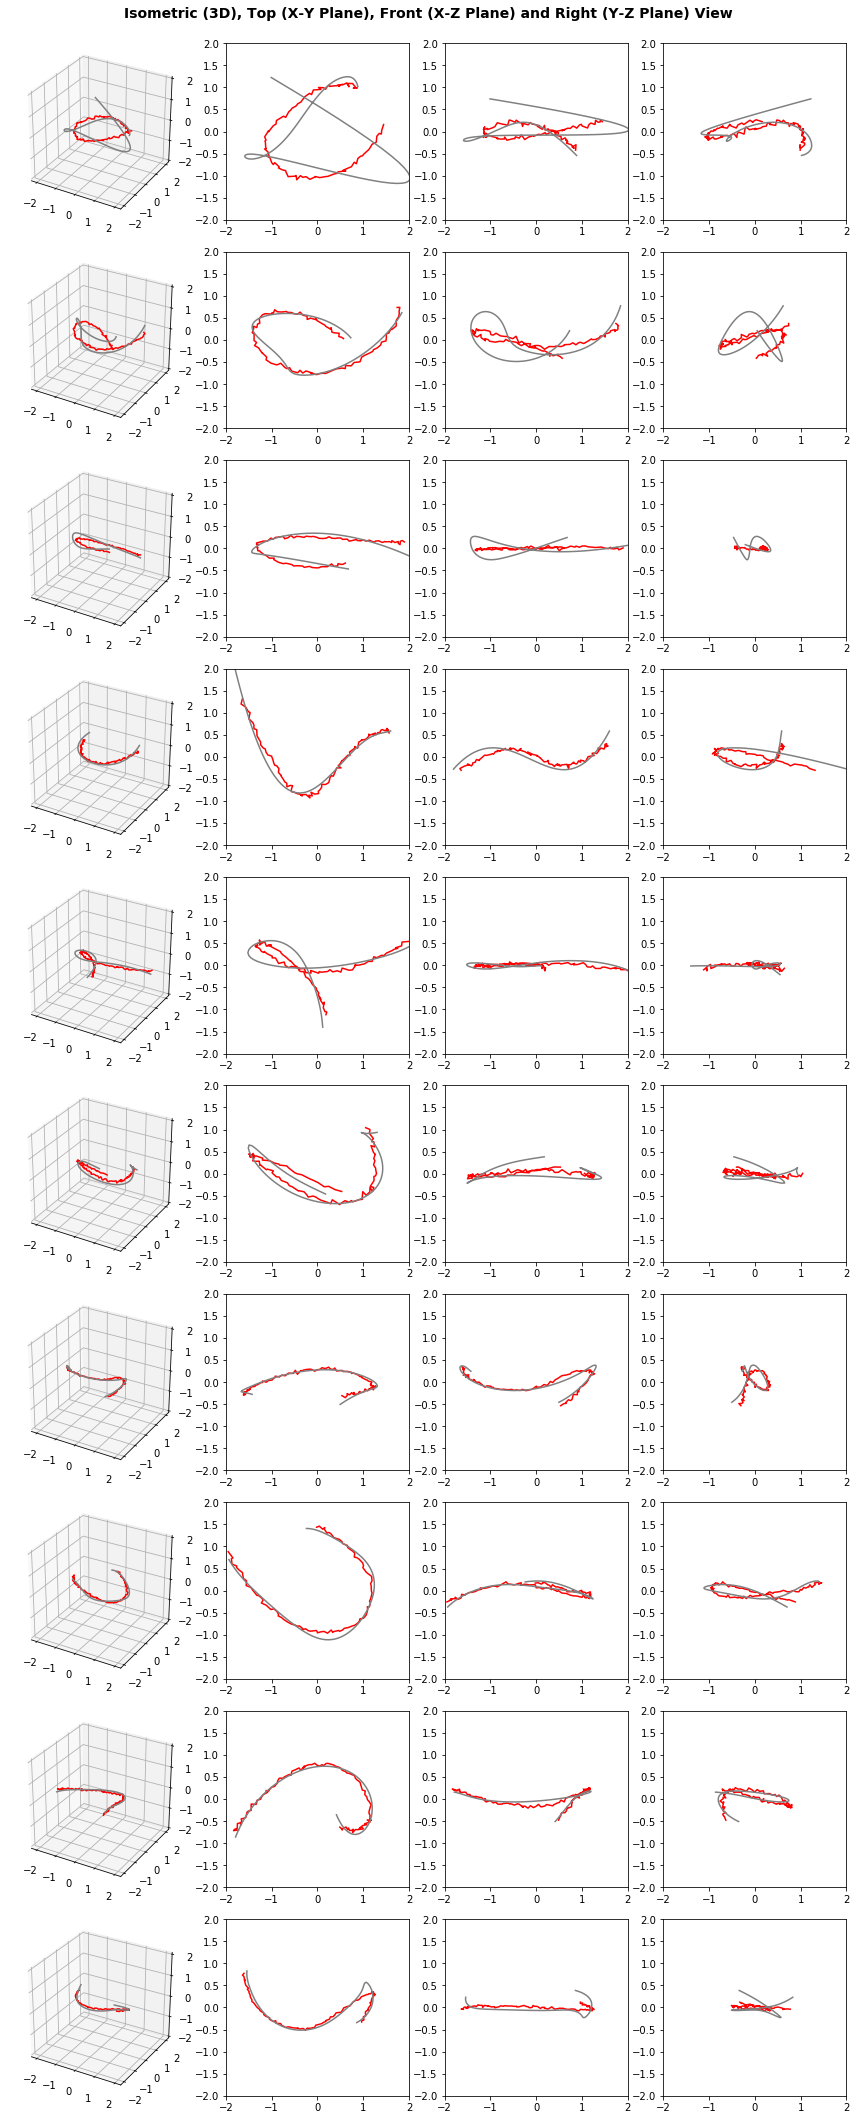

In [72]:
def autoEncoderZ30_Deep():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(150, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(80, activation='relu')(x)
    x=Dense(60, activation='relu')(x)
    x=Dense(40, activation='relu')(x)
    encoded=Dense(30, activation='relu')(x)

    # Decoding
    x=Dense(40, activation='relu')(encoded)
    x=Dense(60, activation='relu')(x)
    x=Dense(80, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderZ30_Deep, 10, x_train, x_test, filename='Z30_Deep')
visualize_AE(AE, train_data, x_test)

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00202: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00176: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00157: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00120: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00146: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00168: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00218: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00228: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00182: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00115: early stopping
[0.0059, 0.0062, 0.0061, 0.0067, 0.0059, 0.0055, 

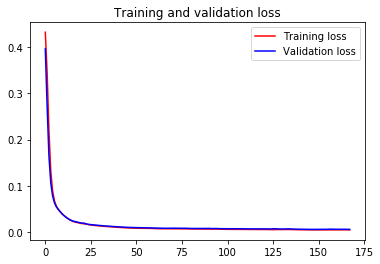

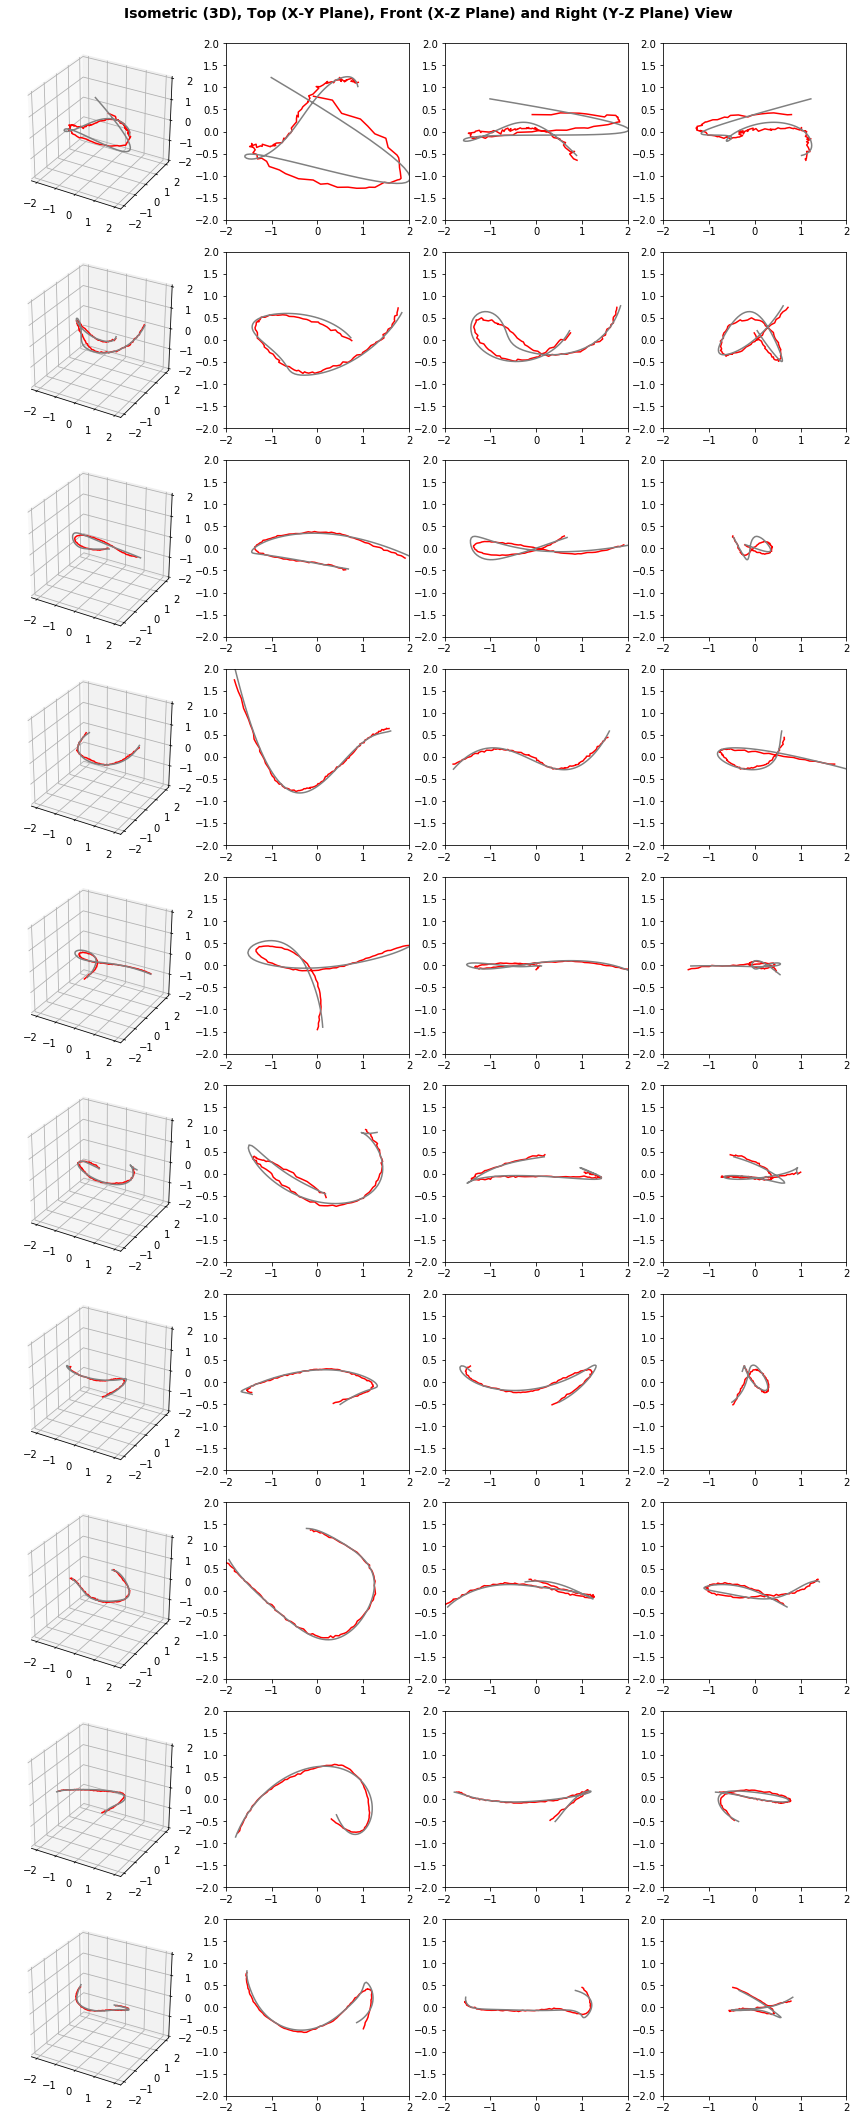

In [71]:
def autoEncoderRZ30_Shallow():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    encoded=Dense(30, activation='relu',activity_regularizer=regularizers.l1(10e-7))(x)

    # Decoding
    x=Dense(100, activation='relu')(encoded)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderRZ30_Shallow, 10, x_train, x_test, filename='RZ30_Shallow')
visualize_AE(AE, train_data, x_test)

Model no. 1
Restoring model weights from the end of the best epoch
Epoch 00156: early stopping
Model no. 2
Restoring model weights from the end of the best epoch
Epoch 00280: early stopping
Model no. 3
Restoring model weights from the end of the best epoch
Epoch 00148: early stopping
Model no. 4
Restoring model weights from the end of the best epoch
Epoch 00188: early stopping
Model no. 5
Restoring model weights from the end of the best epoch
Epoch 00160: early stopping
Model no. 6
Restoring model weights from the end of the best epoch
Epoch 00167: early stopping
Model no. 7
Restoring model weights from the end of the best epoch
Epoch 00248: early stopping
Model no. 8
Restoring model weights from the end of the best epoch
Epoch 00198: early stopping
Model no. 9
Restoring model weights from the end of the best epoch
Epoch 00172: early stopping
Model no. 10
Restoring model weights from the end of the best epoch
Epoch 00132: early stopping
[0.0025, 0.0024, 0.0034, 0.0029, 0.0032, 0.0031, 

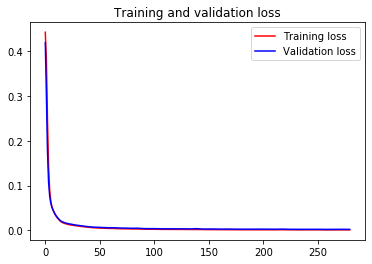

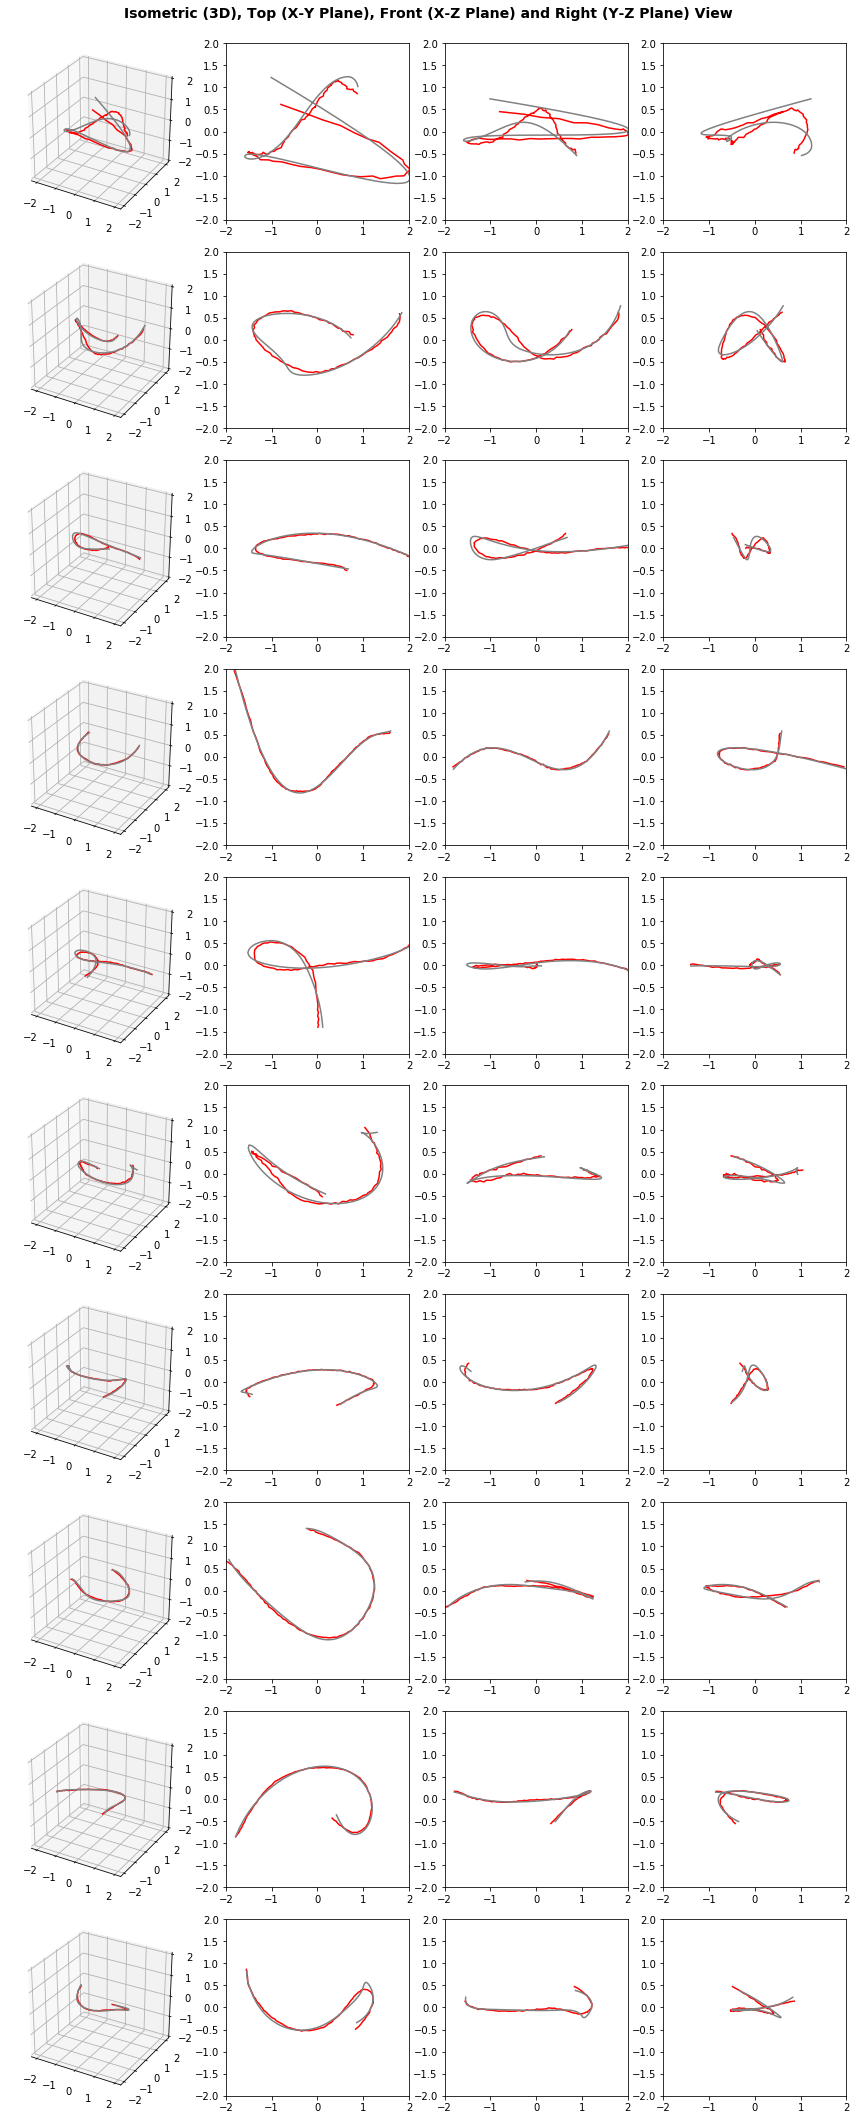

In [73]:
def autoEncoderZ30_Shallow():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    encoded=Dense(30, activation='relu')(x)

    # Decoding
    x=Dense(100, activation='relu')(encoded)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

#resetRNG(0)
AE,E,train_data =AE_analysis(autoEncoderZ30_Shallow, 10, x_train, x_test, filename='Z30_Shallow')
visualize_AE(AE, train_data, x_test)